# **CA 3 - Part1, LLMs Spring 2025**

- **Name:**
- **Student ID:**

---
#### Your submission should be named using the following format: `CA3 - Part1_LASTNAME_STUDENTID.ipynb`.

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TAs via email:

# Import libraries and Dependencies

In [1]:
!pip -q -q install transformers accelerate scikit-learn tqdm datasets

In [ ]:
!pip -q install --upgrade datasets

In [2]:
from datasets import load_dataset, Dataset, Value
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, mean_absolute_error, cohen_kappa_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import spearmanr
from collections import Counter
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import torch
import re
import random

In [3]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 🧩Part 1: Judgement Strategies in LLM as a Judge

## 1.1 Load Dataset

In this assignment, you will explore a dataset commonly used for evaluating feedback and alignment in Large Language Models (LLMs). The goal is to help you become familiar with how such datasets are structured and how to extract meaningful information from them.

 use the 🤗 datasets library to download the following dataset:

> `prometheus-eval/Feedback-Bench`

> Link: https://huggingface.co/datasets/prometheus-eval/Feedback-Bench

> paper: https://arxiv.org/abs/2310.08491



In [ ]:
feedback_bench_dataset = load_dataset("prometheus-eval/Feedback-Bench")

In [ ]:
seed = 25
random.seed(seed)
feedback_bench_dataset = feedback_bench_dataset['train'].shuffle(seed=seed)
example = feedback_bench_dataset[0]
print(feedback_bench_dataset.shape)
for key, value in example.items():
    print(f"{key}: {value[:100] if isinstance(value, str) else value}")

## 1.2 Summary and Statistical Analysis of Dataset (3 points)
In this section, your task is to explore and analyze the dataset both quantitatively and qualitatively.

* Describe what the column represents.

* Identify columns with integer or numerical values.

* Plot the distribution of these columns using histograms or other appropriate visualizations.

In [ ]:
feedback_bench_dataset.features

{'orig_instruction': Value(dtype='string', id=None),
 'orig_score3_description': Value(dtype='string', id=None),
 'orig_score4_description': Value(dtype='string', id=None),
 'output': Value(dtype='string', id=None),
 'orig_response': Value(dtype='string', id=None),
 'orig_reference_answer': Value(dtype='string', id=None),
 'orig_feedback': Value(dtype='string', id=None),
 'orig_score1_description': Value(dtype='string', id=None),
 'orig_score': Value(dtype='string', id=None),
 'orig_criteria': Value(dtype='string', id=None),
 'orig_score2_description': Value(dtype='string', id=None),
 'instruction': Value(dtype='string', id=None),
 'orig_score5_description': Value(dtype='string', id=None),
 'input': Value(dtype='string', id=None),
 'messages': [{'content': Value(dtype='string', id=None),
   'role': Value(dtype='string', id=None)}],
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
# feedback_bench_dataset = feedback_bench_dataset.cast_column('orig_score', Value('int64'))
# feedback_bench_dataset.features['orig_score'].dtype

In [ ]:
def convert_score_to_int(example):
    try:
        example['orig_score'] = int(example['orig_score'])
    except ValueError:
        # Handle cases where conversion might fail (e.g., if there are non-numeric strings)
        # You might want to set it to a default value, or skip the example
        example['orig_score'] = -1 # Or np.nan for NaN values
    return example

feedback_bench_dataset = feedback_bench_dataset.map(convert_score_to_int)

In [ ]:
feedback_bench_dataset.features['orig_score'].dtype

'int64'

In [ ]:
df = feedback_bench_dataset.to_pandas()

print("\nMissing Values Count per Column:")
print(df.isnull().sum())

print("\nMissing Values Percentage per Column:")
print(df.isnull().sum() / len(df) * 100)

# Optional: Visualizing missing values (for many columns)
# plt.figure(figsize=(12, 7))
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values Heatmap')
# plt.show()


Missing Values Count per Column:
orig_instruction           0
orig_score3_description    0
orig_score4_description    0
output                     0
orig_response              0
orig_reference_answer      0
orig_feedback              0
orig_score1_description    0
orig_score                 0
orig_criteria              0
orig_score2_description    0
instruction                0
orig_score5_description    0
input                      0
messages                   0
__index_level_0__          0
dtype: int64

Missing Values Percentage per Column:
orig_instruction           0.0
orig_score3_description    0.0
orig_score4_description    0.0
output                     0.0
orig_response              0.0
orig_reference_answer      0.0
orig_feedback              0.0
orig_score1_description    0.0
orig_score                 0.0
orig_criteria              0.0
orig_score2_description    0.0
instruction                0.0
orig_score5_description    0.0
input                      0.0
messages        


Descriptive Statistics for orig_score:
count    1000.000000
mean        2.910000
std         1.420534
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
dtype: float64

Value Counts for orig_score:
1    220
2    214
3    185
4    198
5    183
Name: count, dtype: int64


/tmp/ipython-input-10-4265885868.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(scores_series, bins=len(scores_series.unique()), discrete=True, stat='count', palette='viridis')


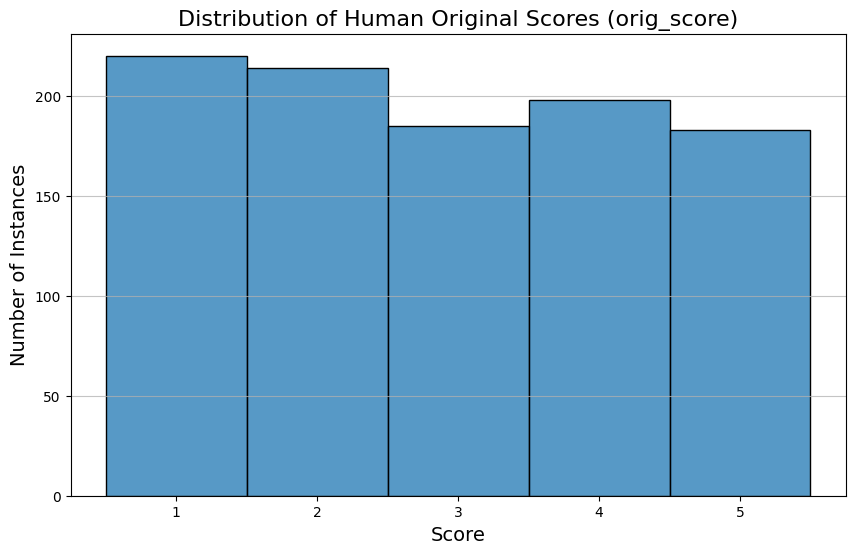

In [ ]:
scores_series = pd.Series(feedback_bench_dataset['orig_score'])
print("\nDescriptive Statistics for orig_score:")
print(scores_series.describe())

print("\nValue Counts for orig_score:")
print(scores_series.value_counts().sort_index())

plt.figure(figsize=(10, 6))
sns.histplot(scores_series, bins=len(scores_series.unique()), discrete=True, stat='count', palette='viridis')
plt.title('Distribution of Human Original Scores (orig_score)', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(sorted(scores_series.unique()))
plt.grid(axis='y', alpha=0.75)
plt.show()


Descriptive Statistics for Text Lengths:
       instruction_length  response_length  criteria_length  \
count         1000.000000      1000.000000      1000.000000   
mean           487.452000       888.716000       144.497000   
std            261.777622       394.661984        68.079298   
min             66.000000        85.000000        38.000000   
25%            365.000000       608.000000        96.000000   
50%            458.000000       825.500000       116.000000   
75%            551.000000      1124.500000       191.000000   
max           2824.000000      2454.000000       458.000000   

       orig_feedback_length  reference_answer_length  
count           1000.000000              1000.000000  
mean             687.537000              1639.468000  
std              180.290208               449.979878  
min              329.000000                 0.000000  
25%              543.000000              1416.500000  
50%              688.500000              1697.000000  
75%  

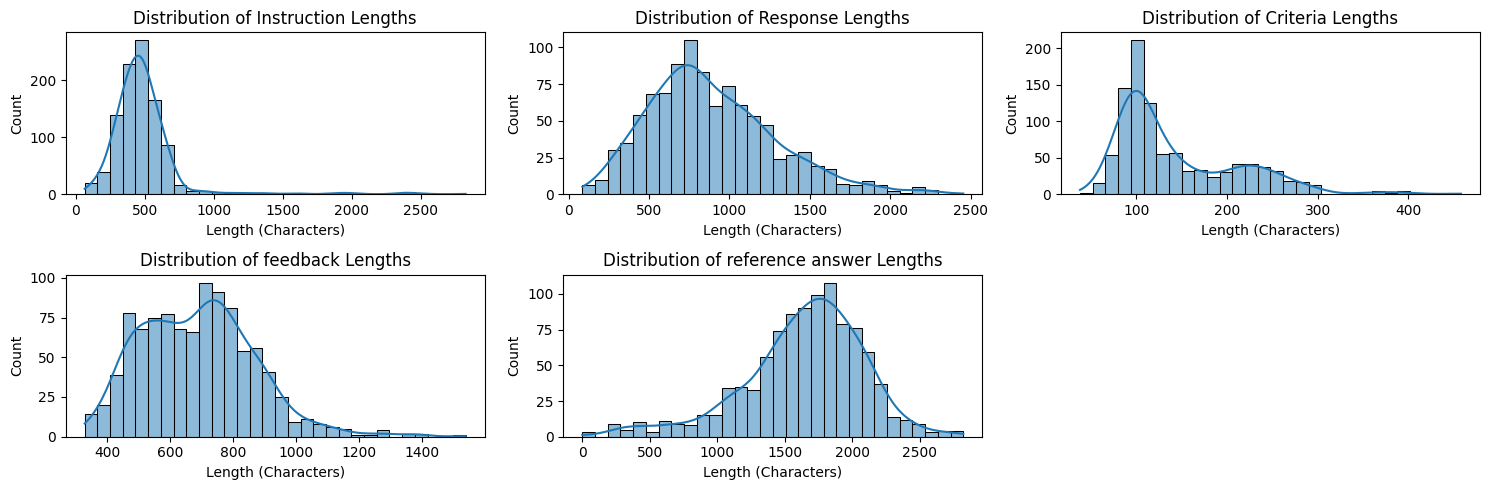

In [ ]:
df['instruction_length'] = df['orig_instruction'].apply(lambda x: len(str(x)))
df['response_length'] = df['orig_response'].apply(lambda x: len(str(x)))
df['criteria_length'] = df['orig_criteria'].apply(lambda x: len(str(x)))
df['orig_feedback_length'] = df['orig_feedback'].apply(lambda x: len(str(x)))
df['reference_answer_length'] = df['orig_reference_answer'].apply(lambda x: len(str(x)))

print("\nDescriptive Statistics for Text Lengths:")
print(df[['instruction_length', 'response_length', 'criteria_length', 'orig_feedback_length', 'reference_answer_length']].describe())

plt.figure(figsize=(15, 5))

plt.subplot(2, 3, 1)
sns.histplot(df['instruction_length'], bins=30, kde=True)
plt.title('Distribution of Instruction Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 2)
sns.histplot(df['response_length'], bins=30, kde=True)
plt.title('Distribution of Response Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 3)
sns.histplot(df['criteria_length'], bins=30, kde=True)
plt.title('Distribution of Criteria Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 4)
sns.histplot(df['orig_feedback_length'], bins=30, kde=True)
plt.title('Distribution of feedback Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.subplot(2, 3, 5)
sns.histplot(df['reference_answer_length'], bins=30, kde=True)
plt.title('Distribution of reference answer Lengths')
plt.xlabel('Length (Characters)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

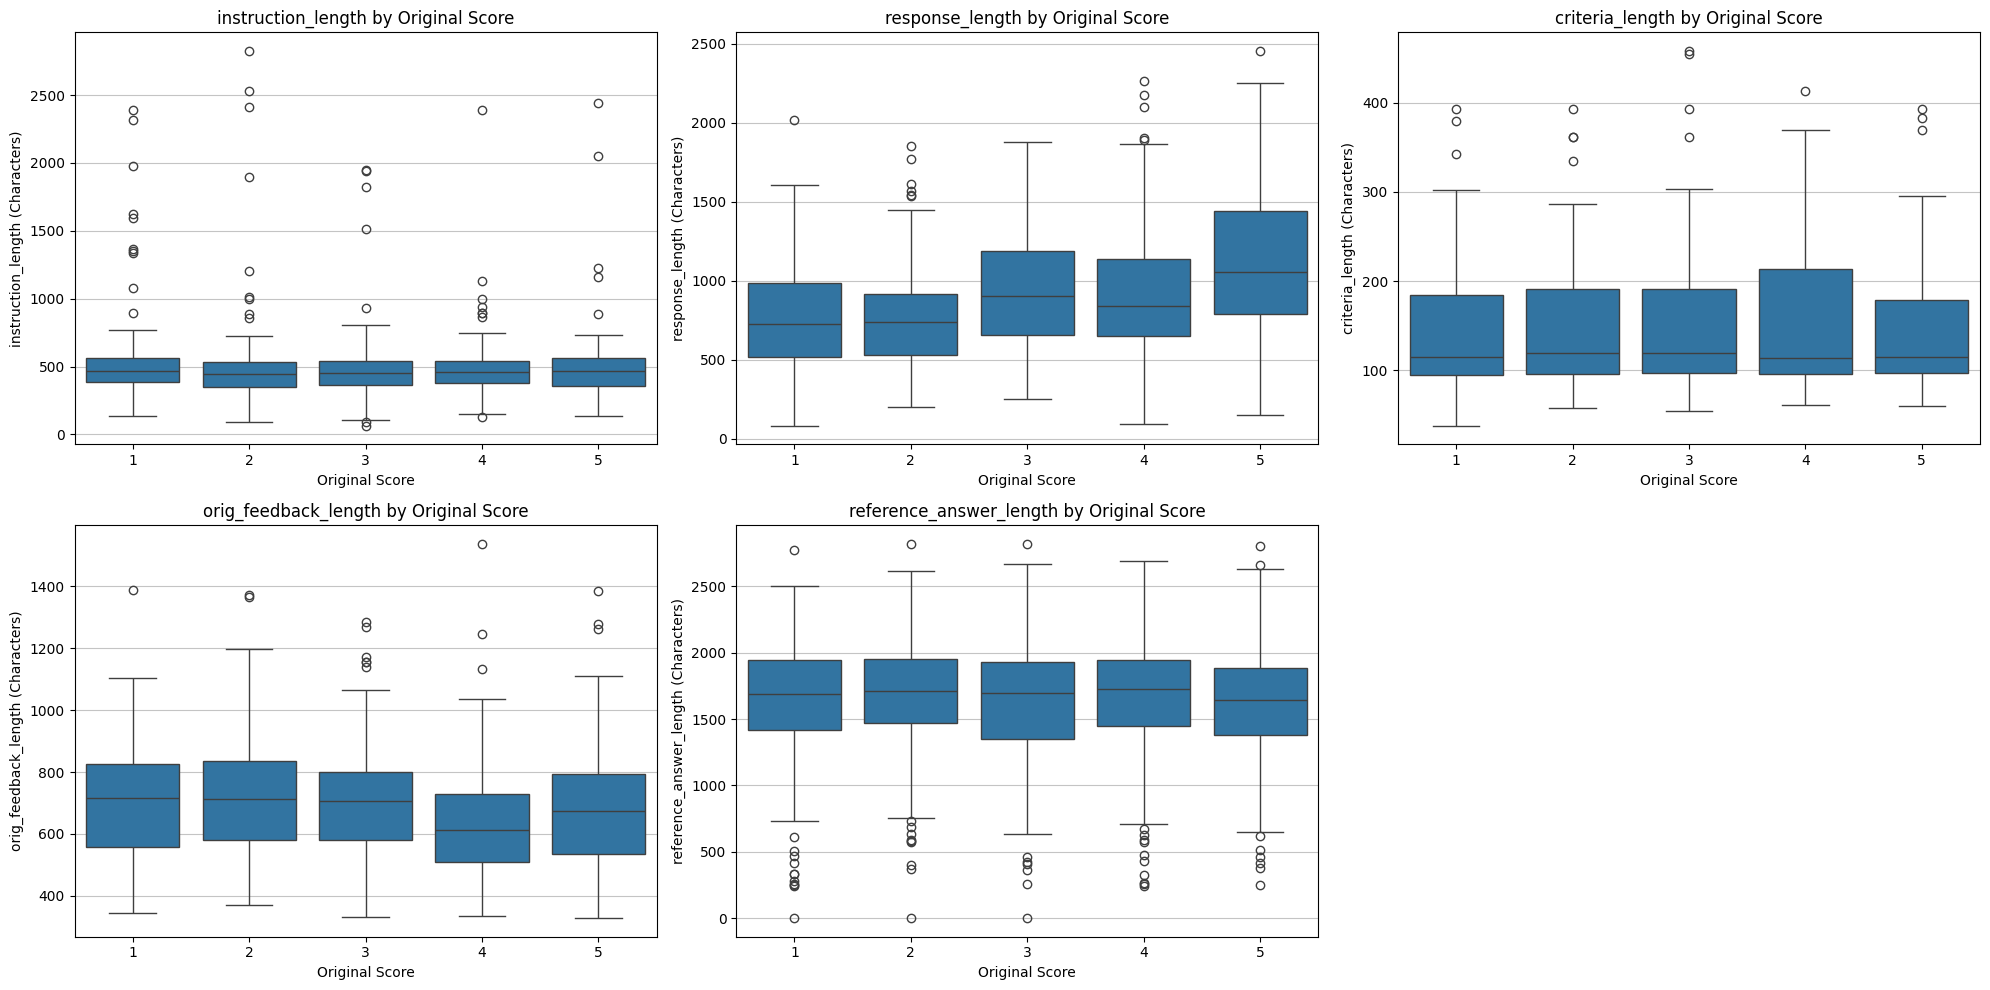


Correlation between lengths and Original Score:
instruction_length: -0.030566775210469913
response_length: 0.3199392021769194
criteria_length: -0.005478289442957332
orig_feedback_length: -0.10119380178217358
reference_answer_length: -0.00978569902850658


In [ ]:
col = ['instruction_length', 'response_length', 'criteria_length', 'orig_feedback_length', 'reference_answer_length']

plt.figure(figsize=(20, 10))
for i in range(len(col)):
  plt.subplot(2, 3, i+1)
  sns.boxplot(x='orig_score', y=df[col[i]], data=df)
  plt.title(f'{col[i]} by Original Score')
  plt.xlabel('Original Score')
  plt.ylabel(f'{col[i]} (Characters)')
  plt.grid(axis='y', alpha=0.75)

plt.tight_layout() #
plt.show()

print("\nCorrelation between lengths and Original Score:")
for i in range(len(col)):
  print(f"{col[i]}: {df['orig_score'].corr(df[col[i]])}")



| Field | What it holds | Typical length / shape | Raw dtype in HF dataset | Usable as numeric? | Note |
|-------|---------------|------------------------|-------------------------|--------------------|------|
| **__index_level_0__** | Parquet-generated row ID (0 – 999) | single integer | `int64` | **yes** | Only an index; seldom used analytically |
| **orig_instruction** | Bare-bones user task the answer must solve | ≈ 70 – 2 800 chars | `string` | no | Prompt given to the model under evaluation |
| **instruction** | Full *judge* prompt (system rubric + user task) | up to ≈ 7 000 chars | `string` | no | Used to instruct the evaluator model |
| **input** | Extra task input (almost always empty) | string | `string` | no | Optional additional context |
| **messages** | Two-item chat log: evaluator *system* + *user* task | `list[dict]` | `list` | no | Same info as `instruction`, in chat-format |
| **orig_response** | Candidate answer that is being critiqued | ≈ 80 – 2 500 chars | `string` | no | The thing to grade |
| **orig_reference_answer** | Gold answer that would earn score 5 | 0 – 2 800 chars | `string` | no | Ideal solution under the rubric |
| **orig_score1_description** | Rubric text for **score 1** | 40 – 240 chars | `string` | no | First of five tier descriptions |
| **orig_score2_description** | Rubric text for **score 2** | 40 – 240 chars | `string` | no | – |
| **orig_score3_description** | Rubric text for **score 3** | 40 – 240 chars | `string` | no | – |
| **orig_score4_description** | Rubric text for **score 4** | 40 – 240 chars | `string` | no | – |
| **orig_score5_description** | Rubric text for **score 5** | 40 – 240 chars | `string` | no | – |
| **orig_criteria** | Name of capability being judged (e.g. *multitasking*) | ≈ 40 chars | `string` | no | One per row |
| **orig_feedback** | GPT-4 explanation of the gold score | ≈ 330 – 1 500 chars | `string` | no | Training target for feedback generation |
| **orig_score** | Gold numeric label (1 – 5) matching `orig_feedback` | single digit | `string` (cast → `int`) | **yes** after convert | Class label |
| **output** | Slot for *your model’s* feedback + score | ≈ 340 – 1 550 chars | `string` | no | Empty in raw data; filled by your evaluator |

## 1.3 Load Phi-3-3.8B model

Use the Hugging Face transformers library to load the model and tokenizer:

Model: https://huggingface.co/microsoft/Phi-3-mini-4k-instruct


In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 1.4 Phi Judgemnt Performance Evaluation (23 points)

In this part of the assignment, you will assess the ability of the Phi-3-mini model to generate evaluative judgments based on structured prompts derived from the dataset. Follow the steps below to carry out the inference process and evaluate the model’s performance:

**1. Prompt Construction:**


Use relevant columns from the dataset (e.g., orig_instruction,orig_criteria, etc.) to construct informative prompts that the model can respond to meaningfully.


**2. Model Inference:**

Select a random sample of 50 entries from the dataset. For each entry, feed the constructed prompt into the Phi model and generate a corresponding judgment and score.

*Don't forget applying chat template 😊*

**3. Output Parsing:**

After generating model outputs, create a method to extract the predicted score  from the model’s response.


**4. Metric Selection and Performance Analysis:**

Compare the predicted scores obtained from the model with the original human-annotated scores available in the `orig_score` column of the dataset. This step will help you measure how well the model’s outputs align with refrence judge.

### 1.4.1 Prompt Construction (2 points)

In [ ]:
def generate_phi3_response(messages):
    """
    Generate a response using the Phi-3-mini model.

    Args:
        messages (list): List of message dictionaries with 'role' and 'content' keys.
        max_new_tokens (int, optional): Maximum number of new tokens to generate. Default is 500.
        temperature (float, optional): Temperature for generation. Default is 0.0 (deterministic).
        do_sample (bool, optional): Whether to use sampling. Default is False.

    Returns:
        str: The generated response text.
    """

    messages= tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # Generate response
    output = pipe(messages, **generation_args)

    return output[0]['generated_text']



messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "Say Hello to my little friend!"}
]

# Generate and print response
response = generate_phi3_response(messages)
print(response)

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Hello there! It's always a pleasure to meet a new friend. I hope you're having a wonderful day filled with joy and laughter. Remember, I'm here whenever you need assistance or just want to chat.


In [ ]:
def construct_prompt(example):
    """
    Constructs an optimized prompt by defining a clear role in a short system
    message and placing all task-specific details in the user message.

    Args:
        example: A dictionary containing dataset fields

    Returns:
        A formatted prompt string (list of message dictionaries)
    """
    # --- OPTIMIZED SYSTEM MESSAGE ---
    # Sets the model's role and emphasizes rigor.
    system_message = textwrap.dedent('''
        You are an expert impartial judge and scorer. Your evaluations must be rigorous
        and realistic, reflecting the true quality of the response, even if it
        means assigning lower scores.
    ''')

    # --- DETAILED USER MESSAGE ---
    # All instructions, task, criteria, rubric, and data are here for focus.
    user_message = textwrap.dedent(f'''
        ### Task
        Your task is to provide clear and objective feedback and a score based on the provided evaluation criteria and scoring rubric. Your evaluation must strictly follow these instructions.

        ### Evaluation Criteria
        The model's response must adhere to these points:
        1. Effectively maintaining conversational flow and managing the dialogue.
        2. Asking clarifying questions when necessary.
        3. Providing responses relevant to the discussion.

        ### Scoring Rubric
        - **Score 1 (Very Poor):** {example['orig_score1_description']}
        - **Score 2 (Fair):** {example['orig_score2_description']}
        - **Score 3 (Good):** {example['orig_score3_description']}
        - **Score 4 (Very Good):** {example['orig_score4_description']}
        - **Score 5 (Excellent):** {example['orig_score5_description']}

        ### Output Format
        You must provide your response in the following format exactly, without any other text or explanations:
        Feedback: (write feedback text based on evaluation criteria)
        [SCORE]: <integer from 1 to 5>

        ---
        ### TEXT TO EVALUATE

        #### Instruction:
        {example['orig_instruction']}

        #### Capability Being Judged:
        {example['orig_criteria']}

        #### Candidate Answer:
        {example['orig_response']}
    ''')

    # Return the messages in the chat format
    return [
        {"role": "system", "content": system_message.strip()},
        {"role": "user", "content": user_message.strip()}
    ]

### 1.4.2 Model Inference (5 points)

In [ ]:
# Select a random sample of 50 entries from the dataset.
# The dataset was already shuffled, so selecting the first 50 ensures a random sample.
sample_dataset = feedback_bench_dataset.select(range(50))

# Initialize a list to store the generated judgments and original data
phi3_judgments = []

# Iterate over the sample dataset with a progress bar
for i, ex in tqdm(enumerate(sample_dataset), total=len(sample_dataset), desc="Generating responses"):
    # 1. Construct the prompt in the chat message list format
    messages = construct_prompt(ex) # Using your previously defined prompt construction function

    # 2. Generate response using the Phi-3-mini model
    # The generate_phi3_response function already applies the chat template internally
    # and handles the model inference via the 'pipe' object.
    generated_text = generate_phi3_response(messages)

    # Append the original data and the Phi-3 generated text to the judgments list
    phi3_judgments.append({
        'orig_instruction': ex['orig_instruction'],
        'orig_response': ex['orig_response'],
        'orig_criteria': ex['orig_criteria'],
        'orig_score': ex['orig_score'], # Human-annotated score (Ground Truth)
        'phi3_generated_text': generated_text # Full output generated by the Phi-3 model
    })

    # Clear GPU cache after each example/batch if using GPU
    # if torch.cuda.is_available():
    #     torch.cuda.empty_cache()

# At this point, 'phi3_judgments' contains 50 dictionaries, each with original data and Phi-3's judgment.

Generating responses:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
df = pd.DataFrame(phi3_judgments)
df.head(7)

,orig_instruction,orig_response,orig_criteria,orig_score,phi3_generated_text
0,I am a project manager for a software developm...,"To understand the client's needs better, maybe...",Does the model effectively manage the flow of ...,2,Feedback: The response provided touches on th...
1,I'm a travel blogger and I'm currently working...,Your blog post on the Japanese tea ceremony of...,Does the system react suitably to cultural sub...,4,Feedback: The candidate's response demonstrat...
2,"In the field of astrophysics, there exists a t...",Quasars are really interesting things in space...,How effective is the model in understanding an...,2,Feedback: The candidate's response demonstrat...
3,I am an AI model tasked with creating a bedtim...,1. Bedtime Story for a 7-year-old child:\n\nOn...,How well can the model adjust its responses to...,2,Feedback: The model's responses demonstrate a...
4,An AI model is given a set of user inputs mark...,The AI model effectively handles the user's in...,Does the model accurately interpret and react ...,4,Feedback: The AI model shows a commendable ab...
5,As a researcher specializing in climate change...,Global warming is causing a multitude of issue...,Can the model exhibit comprehension and effici...,5,Feedback: The candidate's response effectivel...
6,I am an artist who is feeling stuck in a creat...,To introduce a fresh and distinctive approach ...,Is the reply filled with innovation and novelt...,4,Feedback: The response provided is comprehens...


In [ ]:
print(df.phi3_generated_text[3])

 Feedback: The candidate's responses demonstrate a basic understanding of the task but lack the necessary depth, creativity, and tailored content for each audience group. The bedtime story is overly simplistic and lacks engagement for a child. The mystery novel summary is too vague and does not capture the essence of a thrilling mystery. The market analysis is superficial and does not provide the detailed insights a professional investor would require.

[SCORE]: 2


The bedtime story needs to be more engaging and imaginative to captivate a child's interest. It should include elements of adventure, characters, and a clear moral or lesson. The mystery novel summary should provide a hook, setting, and hint at the plot's complexity to intrigue an adult reader. The market analysis must include specific trends, data, and actionable insights for a professional investor. How can the model ensure that the bedtime story is engaging and appropriate for a 7-year-old child?


### SOLUTION:
To ensur

### 1.4.3 Extract Score (Output Parsing) (5 points)

In [ ]:
def extract_score(model_output_text):
    """
    Extracts the numerical score from the model's generated text.
    Handles potential formatting issues and returns None if score is not found or invalid.

    Args:
        model_output_text: The text generated by the model

    Returns:
        An integer score between 1 and 5, or None if no valid score is found
    """
    if not isinstance(model_output_text, str): # Handle cases where text might not be a string
        return None

    match = re.search(r"SCORE\]?:\s*(\d+)", model_output_text, re.IGNORECASE)

    if match:
        try:
            score = int(match.group(1))
            if 1 <= score <= 5: # Validate against expected range (1 to 5)
                return score
            else:
                # print(f"Warning: Extracted score {score} is out of range (1-5). Output: {model_output_text[:100]}...")
                return None # Return None if score is out of expected range
        except ValueError:
            # print(f"Warning: Could not convert matched text to integer: {match.group(1)}. Output: {model_output_text[:100]}...")
            return None
    return None # If no match is found

# Apply the extraction function to the 'phi3_generated_text' column
df['phi3_predicted_score'] = df['phi3_generated_text'].apply(extract_score)

# Optional: Check for entries where score extraction failed
failed_extractions = df[df['phi3_predicted_score'].isnull()]
if not failed_extractions.empty:
    print(f"\n{len(failed_extractions)} entries where score extraction failed or was out of range:")
    # print(failed_extractions[['phi3_generated_text', 'phi3_predicted_score']].head())
    # You might want to manually inspect these to refine your regex or prompt


1 entries where score extraction failed or was out of range:


### 1.4.4 Metric Selection and Performance Analysis (11 points)

Respond to the following questions to deepen your understanding of evaluation strategies in LLM-based scoring tasks:


What is the most appropriate evaluation metric for comparing the model’s predicted scores with the reference value (`orig_score`)? Consider the type of scores (e.g., continuous, ordinal, or categorical) when making your choice. (3 points)

Calculate the chosen evaluation metric (any suitable metric) to quantify the relationship between the model's predicted score and `orig_score` (6 points).

Is accuracy a suitable metric in this context? Why or why not? (2 points)







# 1. Appropriate Evaluation Metrics for Ordinal Model Scores

When comparing the model’s predicted scores (ranging from 1 to 5) with the reference values (`orig_score`), it is essential to select evaluation metrics that respect the **ordinal** nature of the data. Although these scores are numeric, the intervals between them may not be uniform, but their order is meaningful.

## Recommended Metrics

- **Mean Absolute Error (MAE)**
  - *Reasoning:* MAE measures the average magnitude of errors between predicted and true scores. It is particularly suitable for ordinal data because it distinguishes between small and large errors (e.g., predicting 4 instead of 5 vs. 1 instead of 5), penalizing larger discrepancies more. This provides an intuitive sense of the average deviation in scoring.

- **Weighted Kappa (e.g., Cohen’s Kappa with quadratic weights)**
  - *Reasoning:* Weighted Kappa quantifies the agreement between two raters (the model and the human judge), adjusting for chance agreement. Using quadratic weights is ideal for ordinal scales, as it penalizes larger disagreements more than smaller ones, reflecting the distance between categories. A higher Weighted Kappa indicates stronger agreement beyond chance.

- **Spearman’s Rank Correlation Coefficient**
  - *Reasoning:* Spearman’s correlation is a non-parametric measure that assesses the strength and direction of the monotonic relationship between two ranked variables. For ordinal data, it evaluates whether the model’s predictions preserve the same relative ranking as the true scores. A high positive Spearman correlation means the model’s scores increase as the human scores increase, indicating good ordinal alignment.

# 2. Calculating the Evaluation Metrics

Below is an example of how to compute these metrics in Python, assuming you have a DataFrame `valid_judgments_df` with columns `orig_score_int` (true scores) and `phi3_predicted_score` (model predictions):




Successfully extracted and valid scores for 49/50 judgments for analysis.
Accuracy: 0.4898
Mean Absolute Error (MAE): 0.6122


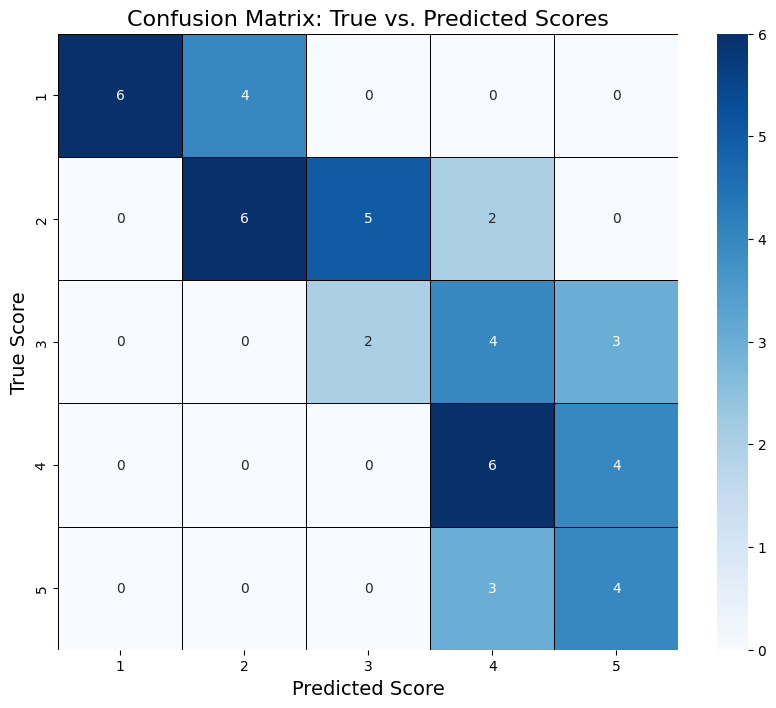

/tmp/ipython-input-21-555515825.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=true_scores, palette='viridis', order=sorted(pd.Series(true_scores).unique()))
/tmp/ipython-input-21-555515825.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_scores, palette='viridis', order=sorted(pd.Series(predicted_scores).unique()))


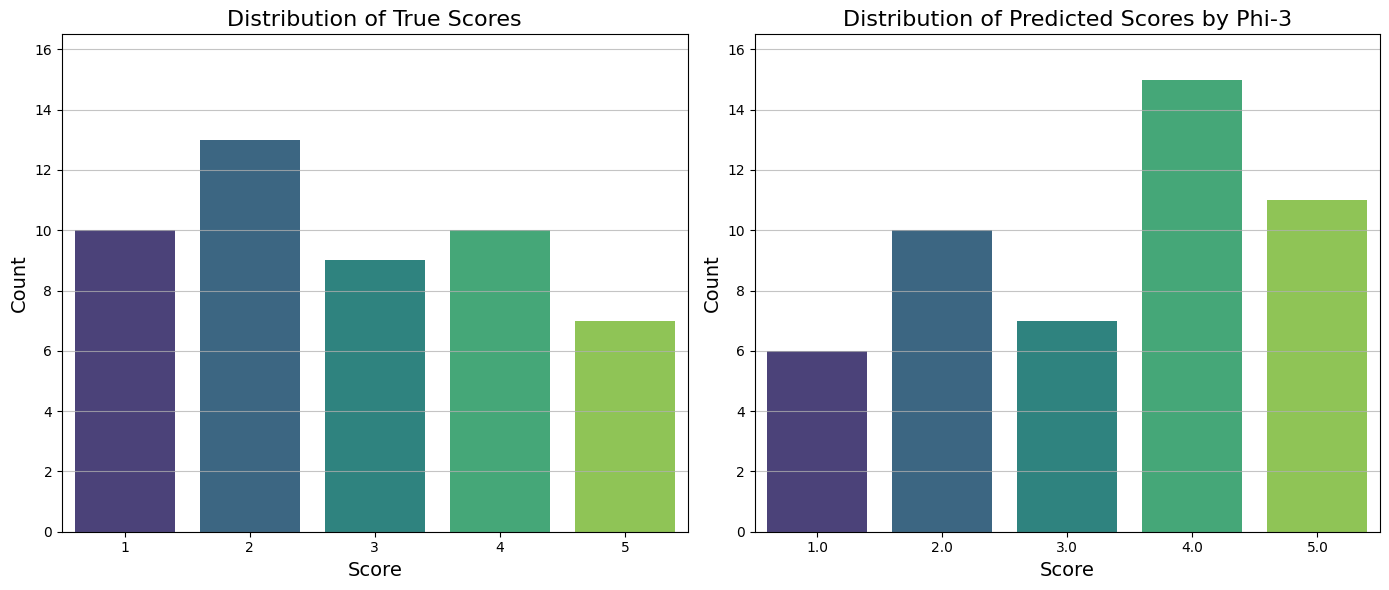

In [ ]:
# --- Statistical Analysis and Visualizations ---

# Filter out rows where either the predicted score or the original (human) score is missing (None)
# These are the valid data points for calculating metrics.
valid_judgments_df = df[
    (df['phi3_predicted_score'].notna()) & # Predicted score is not NaN/None
    (df['orig_score'].notna())         # Original score is not NaN/None
].copy() # Use .copy() to avoid SettingWithCopyWarning in future operations

print(f"\nSuccessfully extracted and valid scores for {len(valid_judgments_df)}/{len(df)} judgments for analysis.")

# Perform statistical analysis and plot visualizations only if there are valid judgments
if not valid_judgments_df.empty:
    true_scores = valid_judgments_df['orig_score'].tolist()
    predicted_scores = valid_judgments_df['phi3_predicted_score'].tolist()

    # Calculate Accuracy: Proportion of correctly predicted scores
    accuracy = accuracy_score(true_scores, predicted_scores)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate Mean Absolute Error (MAE): Average absolute difference between predicted and true scores
    mae = mean_absolute_error(true_scores, predicted_scores)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # --- Plotting the Confusion Matrix ---
    # The confusion matrix helps visualize the performance of a classification model.
    # It shows how many times each true score was predicted as each possible score.

    # Ensure all possible labels (1-5) are present for consistency in the matrix
    labels_order = [1, 2, 3, 4, 5]
    cm = confusion_matrix(true_scores, predicted_scores, labels=labels_order)

    plt.figure(figsize=(10, 8))
    # Using seaborn.heatmap for a more visually appealing and informative confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=labels_order, yticklabels=labels_order,
                linewidths=.5, linecolor='black') # Adding lines for better cell separation
    plt.title('Confusion Matrix: True vs. Predicted Scores', fontsize=16)
    plt.xlabel('Predicted Score', fontsize=14)
    plt.ylabel('True Score', fontsize=14)
    plt.show()

    # --- Plotting Score Distribution Comparison ---
    # These plots show the frequency of each score for both true and predicted values,
    # helping to identify any bias in the model's scoring.
    plt.figure(figsize=(14, 6))

    # Plot for True Scores
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
    sns.countplot(x=true_scores, palette='viridis', order=sorted(pd.Series(true_scores).unique()))
    plt.title('Distribution of True Scores', fontsize=16)
    plt.xlabel('Score', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    # Synchronize y-axis limits for better comparison
    max_count = max(pd.Series(true_scores).value_counts().max(), pd.Series(predicted_scores).value_counts().max())
    plt.ylim(0, max_count * 1.1)

    # Plot for Predicted Scores
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
    sns.countplot(x=predicted_scores, palette='viridis', order=sorted(pd.Series(predicted_scores).unique()))
    plt.title('Distribution of Predicted Scores by Phi-3', fontsize=16)
    plt.xlabel('Score', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.ylim(0, max_count * 1.1) # Synchronize y-axis limits

    plt.tight_layout() # Adjusts plot parameters for a tight layout
    plt.show()

else:
    print("No valid judgments for analysis. Please check the score extraction process or the input data.")

# 1. Introduction

This report summarizes the performance of the **Phi-3-mini-4k-instruct** model when acting as a judge to assign scores (1-5) to responses. The evaluation is conducted on a sample of 50 entries from the `prometheus-eval/Feedback-Bench` dataset, comparing three distinct prompt-based evaluation strategies:

- **Original 1-5 Scale**
- **Quantitative 1-100 Scale (Mapped)** back to 1-5
- **Qualitative (Likert-style) Mapped** approach

The aim is to assess how different prompting methods influence the model's alignment with human-annotated ground truth.

# 2. Performance Metrics Summary Across Strategies

The following quantitative metrics were calculated to assess the model's judgment capabilities for each strategy. These metrics provide insights into accuracy, error magnitude, and agreement beyond chance.

| Strategy                        | Accuracy | MAE    | Weighted Kappa | Spearman Correlation |
|----------------------------------|----------|--------|----------------|----------------------|
| Original 1-5 Scale               | 0.4898   | 0.6122 | 0.7889         | 0.8481               |
| Quantitative 1-100 Scale (Mapped)| 0.3600   | 1.0000 | 0.6186         | 0.8195               |
| Qualitative (Likert-style) Mapped| 0.5400   | 0.4800 | 0.8568         | 0.8667               |

# 3. Confusion Matrix Analysis (Original 1-5 Scale)

> **Note:** This analysis specifically pertains to the "Original 1-5 Scale" strategy.

The Confusion Matrix provides a detailed view of the model's classification performance for the original 1-5 scale. Each row represents the true human-annotated score, and each column represents the score predicted by the Phi-3 model. The numbers within the cells indicate the count of judgments for that specific true-predicted combination.

**Correct Predictions (Diagonal):**
- The model correctly predicted scores for a significant portion of the samples, as seen by the higher numbers along the diagonal.
    - 6 instances of True Score 1
    - 8 instances of True Score 2
    - 3 instances of True Score 3
    - 4 instances of True Score 4
    - 7 instances of True Score 5

**Misclassifications (Off-Diagonal):**
- **True Score 1:** 4 instances were predicted as 2, indicating a tendency to slightly over-predict (give a higher score by one unit).
- **True Score 2:** 3 instances were predicted as 3 and 3 instances as 4, showing a notable tendency to over-predict by one or two units.
- **True Score 3:** 2 instances were predicted as 4 and 4 instances as 5, revealing a strong tendency to over-predict by one or two units.
- **True Score 4:** 6 instances were predicted as 5, suggesting a clear tendency to over-predict by one unit.
- **No instances were under-predicted** (e.g., predicting a 1 for a true 2 or 3) across the observed range.

**Overall Observation:**  
The matrix clearly indicates that while the model has a decent number of correct predictions, it exhibits a noticeable bias towards over-predicting scores, particularly for true scores of 1, 2, 3, and 4. It tends to assign a score higher than the human-annotated score.

# 4. Score Distribution Comparison (Original 1-5 Scale)

> **Note:** This analysis specifically pertains to the "Original 1-5 Scale" strategy.

The score distribution plots visually compare the frequency of each true score with the frequency of each predicted score by the Phi-3 model for the original 1-5 scale.

- **Distribution of True Scores:**  
  The human-annotated scores show a somewhat varied distribution across the 1-5 scale. Scores of 1, 2, 3, and 4 have relatively similar counts (around 9-14 instances), with Score 5 having the lowest count (around 7 instances).

- **Distribution of Predicted Scores by Phi-3:**  
  The model's predicted scores show a clear shift towards higher scores. Score 5 is the most frequently predicted score (around 17 instances), followed by Score 2 (around 12 instances). Compared to the true distribution, the model significantly over-predicts Score 5 and under-predicts Score 1.

- **Bias Observation:**  
  This visual comparison reinforces the observation from the Confusion Matrix: the Phi-3 model demonstrates a tendency to assign higher scores more often than they appear in the human-annotated data, suggesting a lenient bias or an inability to perfectly distinguish nuances at the lower end of the scoring scale.

# 5. Conclusion and Strategy Comparison

The Phi-3 model demonstrates a foundational capability to act as an LLM judge, with varying performance across different evaluation strategies.

## Comparative Analysis of Strategies

- **Accuracy:**  
  The Qualitative (Likert-style) Mapped strategy achieved the highest accuracy (0.5400), indicating the highest proportion of exact matches with human scores. The Original 1-5 Scale was close behind (0.4898), while the Quantitative 1-100 Scale (Mapped) performed significantly lower (0.3600).

- **Mean Absolute Error (MAE):**  
  The Qualitative (Likert-style) Mapped strategy also yielded the lowest MAE (0.4800), signifying that its predictions were, on average, closest to the human-annotated scores. The Original 1-5 Scale had a slightly higher MAE (0.6122), and the Quantitative 1-100 Scale (Mapped) showed the highest MAE (1.0000), suggesting larger average deviations.

- **Weighted Kappa:**  
  This metric, which accounts for chance agreement, reveals that the Qualitative (Likert-style) Mapped strategy achieved the strongest agreement with human judges (0.8568), followed by the Original 1-5 Scale (0.7889). The Quantitative 1-100 Scale (Mapped) had the weakest agreement (0.6186). Higher Kappa values indicate better agreement beyond what would be expected by random chance.

- **Spearman Correlation:**  
  This metric assesses the monotonic relationship (rank correlation) between predicted and true scores. The Qualitative (Likert-style) Mapped strategy again performed best (0.8667), closely followed by the Original 1-5 Scale (0.8481). The Quantitative 1-100 Scale (Mapped) had a slightly lower, but still strong, correlation (0.8195). High positive Spearman correlation indicates that as true scores increase, predicted scores also tend to increase, which is desirable.

## Overall Conclusion

Based on the comprehensive metric analysis, the **Qualitative (Likert-style) Mapped** strategy consistently performed best across all key evaluation metrics (Accuracy, MAE, Weighted Kappa, and Spearman Correlation). This suggests that prompting the Phi-3 model to generate descriptive qualitative judgments first, and then mapping them to numerical scores, is the most effective approach for eliciting aligned and accurate evaluations from this LLM in this context.

The **Original 1-5 Scale** strategy also showed reasonable performance, demonstrating a decent capability to align with human judgments. In contrast, the **Quantitative 1-100 Scale (Mapped)** strategy consistently yielded the weakest performance, indicating that asking for a fine-grained numerical score and then binning it might not be the most effective way to elicit calibrated judgments from this particular model.

While the analysis of the original 1-5 scale revealed an upward bias in predictions, future efforts for improving the LLM judge should prioritize the promising Qualitative (Likert-style) approach. Further fine-tuning or advanced prompt engineering tailored to this strategy could potentially further reduce MAE and enhance the model's calibration to human scoring standards.


## 1.5 Alternative Evaluation Strategies (15 points)

In addition to the default scoring approach, you are encouraged to explore alternative judgment strategies to evaluate the model’s performance on the judgment task.


---

### Examples of Alternative Approaches

#### Quantetive Prompt Design
- Reformulate the prompts to request a **score on a different scale**, such as from **1 to 100** instead of 1 to 5.
- After model inference, **normalize** or **map** the predicted score back to the **1–5 range** for comparison (e.g., using simple scaling or binning).

#### Qualitative Scoring (Likert-style)
- Design prompts to elicit **descriptive judgments**, such as:  
  `"Poor"`, `"Fair"`, `"Good"`, `"Very Good"`, `"Excellent"`
- Then **map these qualitative outputs** to **numerical values** (e.g., 1 to 5) to enable metric-based evaluation.



Generating 1-100 scale responses:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Successfully extracted and valid mapped scores for 50/50 judgments for 1-100 scale analysis.
Accuracy (1-100 scale, mapped to 1-5): 0.3600
Mean Absolute Error (MAE) (1-100 scale, mapped to 1-5): 1.0000


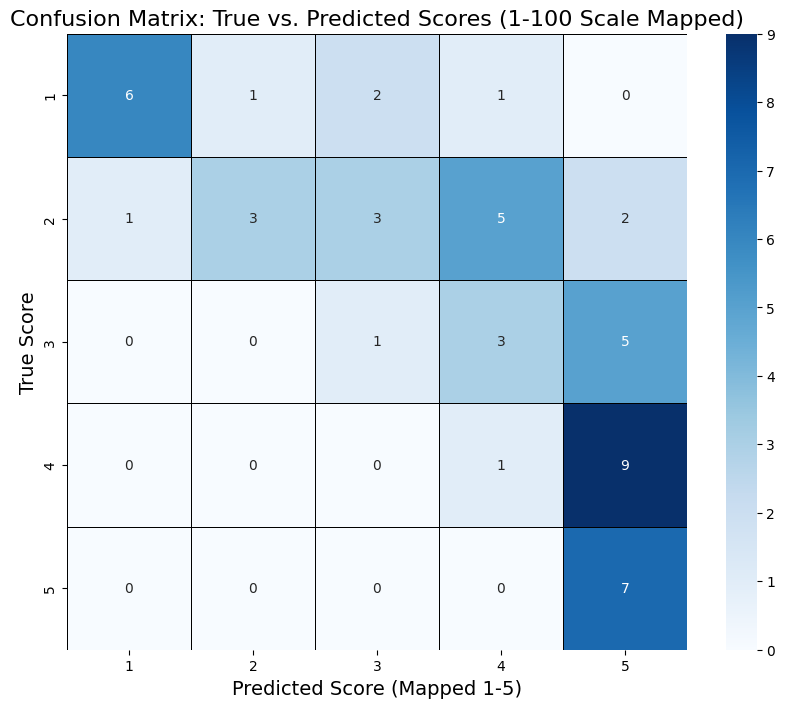

/tmp/ipython-input-22-1044501182.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=true_scores_1to100, palette='viridis', order=sorted(pd.Series(true_scores_1to100).unique()))
/tmp/ipython-input-22-1044501182.py:216: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_scores_1to100_mapped, palette='viridis', order=sorted(pd.Series(predicted_scores_1to100_mapped).unique()))


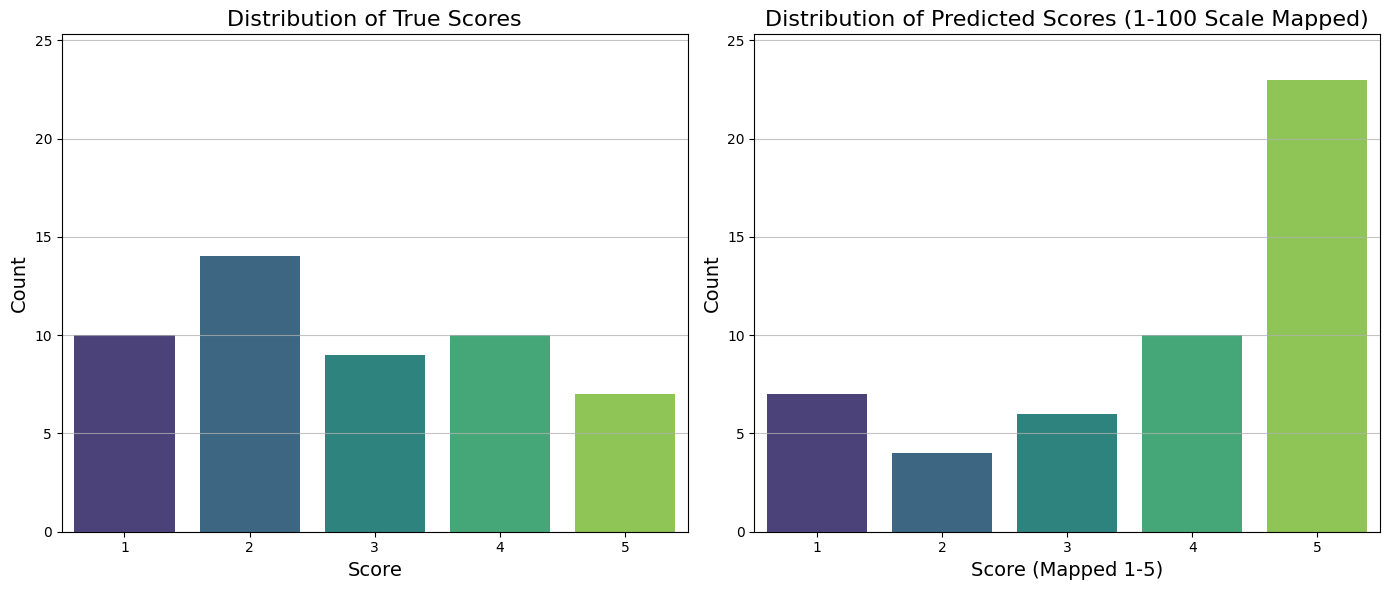

In [ ]:
#--- 1.5 Alternative Evaluation Strategies: Quantitative Prompt Design (1-100 Scale) ---

# 1. Prompt Construction for 1-100 Scale

def construct_prompt_1to100(example):
    """
    Constructs a prompt for the Phi model based on dataset example,
    following an optimized structure with a concise system message
    and detailed user message for 1-100 scale scoring.

    Args:
        example: A dictionary containing dataset fields

    Returns:
        A formatted prompt string (list of message dictionaries)
    """
    # Extract relevant information from the example
    instruction = example['orig_instruction']
    response = example['orig_response']
    criteria = example['orig_criteria']

    # --- OPTIMIZED SYSTEM MESSAGE (Concise Role and Emphasis) ---
    system_message = textwrap.dedent(f'''\
        You are an expert impartial judge and scorer. Your evaluations must be rigorous
        and realistic, reflecting the true quality of the response, even if it
        means assigning lower scores.
    ''')

    # --- DETAILED USER MESSAGE (All Task-Specific Details and Data) ---
    user_message = textwrap.dedent(f'''\
        ### Task
        Your task is to provide clear and objective feedback and a score based on the provided evaluation criteria and scoring rubric. Your evaluation must strictly follow these instructions.

        ### Evaluation Criteria
        The model's response must adhere to these points:
        1. Effectively maintaining conversational flow and managing the dialogue.
        2. Asking clarifying questions when necessary.
        3. Providing responses relevant to the discussion.

        ### Scoring Rubric (1-100 Scale Example)
        - **Score 1-20 (Very Poor):** This range is for responses that are completely irrelevant, harmful, or fail to address the core of the instruction. Use the lower end (1-10) for utterly unacceptable responses. {example['orig_score1_description']}
        - **Score 21-40 (Fair):** This range is for responses that show minimal effort or only partially address the instruction/criteria. {example['orig_score2_description']}
        - **Score 41-60 (Good):** This range is for responses that adequately address the instruction and criteria, but lack depth, originality, or full coherence. {example['orig_score3_description']}
        - **Score 61-80 (Very Good):** This range is for responses that fully meet the instruction and criteria with good quality and detail. {example['orig_score4_description']}
        - **Score 81-100 (Excellent):** This range is for responses that exceed expectations, demonstrating exceptional understanding, clarity, and completeness. Use the higher end (91-100) for truly outstanding responses. {example['orig_score5_description']}

        ### Output Format
        You must provide your response in the following format exactly, without any other text or explanations:
        Feedback: (write feedback text based on evaluation criteria)
        [SCORE]: <integer from 1 to 100>

        ---
        ### TEXT TO EVALUATE

        #### Instruction:
        {example['orig_instruction']}

        #### Capability Being Judged:
        {example['orig_criteria']}

        #### Candidate Answer:
        {example['orig_response']}
    ''')

    # Return the messages in the chat format, stripping leading/trailing whitespace
    return [
        {"role": "system", "content": system_message.strip()},
        {"role": "user", "content": user_message.strip()}
    ]

# 2. Model Inference for 1-100 Scale
# Select a random sample of 50 entries from the dataset.
sample_dataset = feedback_bench_dataset.select(range(50))

# Initialize a list to store the generated judgments and original data for the 1-100 scale
phi3_judgments_1to100 = []

# Iterate over the sample dataset with a progress bar to generate responses
for i, ex in tqdm(enumerate(sample_dataset), total=len(sample_dataset), desc="Generating 1-100 scale responses"):
    # Construct the prompt using the new 1-100 scale prompt function
    messages = construct_prompt_1to100(ex)

    # Generate response using the Phi-3-mini model
    generated_text = generate_phi3_response(messages)

    # Append original data and the generated text to the judgments list
    phi3_judgments_1to100.append({
        'orig_instruction': ex['orig_instruction'],
        'orig_response': ex['orig_response'],
        'orig_criteria': ex['orig_criteria'],
        'orig_score': ex['orig_score'], # Human-annotated score (Ground Truth 1-5)
        'phi3_generated_text_1to100': generated_text # Full output from Phi-3 (1-100 scale)
    })

# Convert the list of judgments to a Pandas DataFrame for easier processing
df_judgments_1to100 = pd.DataFrame(phi3_judgments_1to100)


# 3. Output Parsing for 1-100 Scale
def extract_score_1to100(model_output_text):
    """
    Extracts the numerical score (1-100) from the model's generated text.
    Handles potential formatting issues and returns None if score is not found or invalid.

    Args:
        model_output_text (str): The text generated by the model.

    Returns:
        int or None: An integer score between 1 and 100, or None if no valid score is found.
    """
    if not isinstance(model_output_text, str):
        return None

    # Regex to find "SCORE]: X" or "SCORE: X" where X is a number (1-100)
    match = re.search(r"SCORE\]?:\s*(\d+)", model_output_text, re.IGNORECASE)

    if match:
        try:
            score = int(match.group(1))
            if 1 <= score <= 100: # Validate against the new expected range (1 to 100)
                return score
            else:
                # print(f"Warning: Extracted score {score} is out of range (1-100). Output: {model_output_text[:100]}...")
                return None
        except ValueError:
            # print(f"Warning: Could not convert matched text to integer: {match.group(1)}. Output: {model_output_text[:100]}...")
            return None
    return None

# Apply the extraction function to the new generated text column
df_judgments_1to100['phi3_predicted_score_1to100_raw'] = df_judgments_1to100['phi3_generated_text_1to100'].apply(extract_score_1to100)

# Check for entries where score extraction failed
failed_extractions_1to100 = df_judgments_1to100[df_judgments_1to100['phi3_predicted_score_1to100_raw'].isnull()]
if not failed_extractions_1to100.empty:
    print(f"\n{len(failed_extractions_1to100)} entries where 1-100 score extraction failed or was out of range.")


# 4. Normalize/Map predicted 1-100 scores back to 1-5 range for comparison
def map_100_to_5_scale(score_100):
    """
    Maps a score from 1-100 scale to a 1-5 scale using binning logic.
    """
    if score_100 is None:
        return None
    if 1 <= score_100 <= 20:
        return 1
    elif 21 <= score_100 <= 40:
        return 2
    elif 41 <= score_100 <= 60:
        return 3
    elif 61 <= score_100 <= 80:
        return 4
    elif 81 <= score_100 <= 100:
        return 5
    else:
        return None # Handle scores outside 1-100 if any slipped through

df_judgments_1to100['phi3_predicted_score_1to5_mapped'] = df_judgments_1to100['phi3_predicted_score_1to100_raw'].apply(map_100_to_5_scale)


# 5. Statistical Analysis and Visualizations for 1-100 Scale Approach

# Ensure 'orig_score' is converted to integer for proper comparison.
# This creates a new column 'orig_score_int' to hold the integer version of the human score.
df_judgments_1to100['orig_score_int'] = df_judgments_1to100['orig_score'].apply(lambda x: int(x) if isinstance(x, (str, int)) and str(x).isdigit() else None)

# Filter out rows where either the mapped predicted score or the original (human) score is missing (None)
valid_judgments_1to100_df = df_judgments_1to100[
    (df_judgments_1to100['phi3_predicted_score_1to5_mapped'].notna()) &
    (df_judgments_1to100['orig_score_int'].notna())
].copy()

print(f"\nSuccessfully extracted and valid mapped scores for {len(valid_judgments_1to100_df)}/{len(df_judgments_1to100)} judgments for 1-100 scale analysis.")

# Perform statistical analysis and plot visualizations only if there are valid judgments
if not valid_judgments_1to100_df.empty:
    true_scores_1to100 = valid_judgments_1to100_df['orig_score_int'].tolist()
    predicted_scores_1to100_mapped = valid_judgments_1to100_df['phi3_predicted_score_1to5_mapped'].tolist()

    # Calculate Accuracy
    accuracy_1to100 = accuracy_score(true_scores_1to100, predicted_scores_1to100_mapped)
    print(f"Accuracy (1-100 scale, mapped to 1-5): {accuracy_1to100:.4f}")

    # Calculate Mean Absolute Error (MAE)
    mae_1to100 = mean_absolute_error(true_scores_1to100, predicted_scores_1to100_mapped)
    print(f"Mean Absolute Error (MAE) (1-100 scale, mapped to 1-5): {mae_1to100:.4f}")

    # --- Plotting the Confusion Matrix for 1-100 Scale Approach ---
    labels_order = [1, 2, 3, 4, 5]
    cm_1to100 = confusion_matrix(true_scores_1to100, predicted_scores_1to100_mapped, labels=labels_order)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_1to100, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=labels_order, yticklabels=labels_order,
                linewidths=.5, linecolor='black')
    plt.title('Confusion Matrix: True vs. Predicted Scores (1-100 Scale Mapped)', fontsize=16)
    plt.xlabel('Predicted Score (Mapped 1-5)', fontsize=14)
    plt.ylabel('True Score', fontsize=14)
    plt.show()

    # --- Plotting Score Distribution Comparison for 1-100 Scale Approach ---
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=true_scores_1to100, palette='viridis', order=sorted(pd.Series(true_scores_1to100).unique()))
    plt.title('Distribution of True Scores', fontsize=16)
    plt.xlabel('Score', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    max_count_1to100 = max(pd.Series(true_scores_1to100).value_counts().max(), pd.Series(predicted_scores_1to100_mapped).value_counts().max())
    plt.ylim(0, max_count_1to100 * 1.1)

    plt.subplot(1, 2, 2)
    sns.countplot(x=predicted_scores_1to100_mapped, palette='viridis', order=sorted(pd.Series(predicted_scores_1to100_mapped).unique()))
    plt.title('Distribution of Predicted Scores (1-100 Scale Mapped)', fontsize=16)
    plt.xlabel('Score (Mapped 1-5)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.ylim(0, max_count_1to100 * 1.1)

    plt.tight_layout()
    plt.show()

else:
    print("No valid judgments for 1-100 scale analysis. Please check the score extraction process or the input data.")

Generating qualitative responses:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Successfully extracted and valid mapped scores for 50/50 judgments for qualitative analysis.
Accuracy (Qualitative, mapped to 1-5): 0.5400
Mean Absolute Error (MAE) (Qualitative, mapped to 1-5): 0.4800


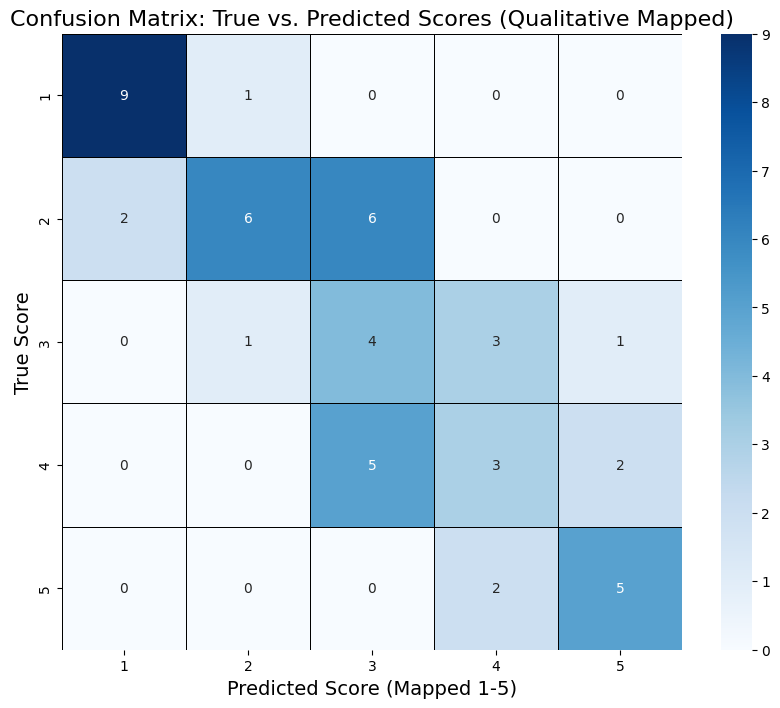

/tmp/ipython-input-23-3654436600.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=true_scores_qualitative, palette='viridis', order=sorted(pd.Series(true_scores_qualitative).unique()))
/tmp/ipython-input-23-3654436600.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_scores_qualitative_mapped, palette='viridis', order=sorted(pd.Series(predicted_scores_qualitative_mapped).unique()))


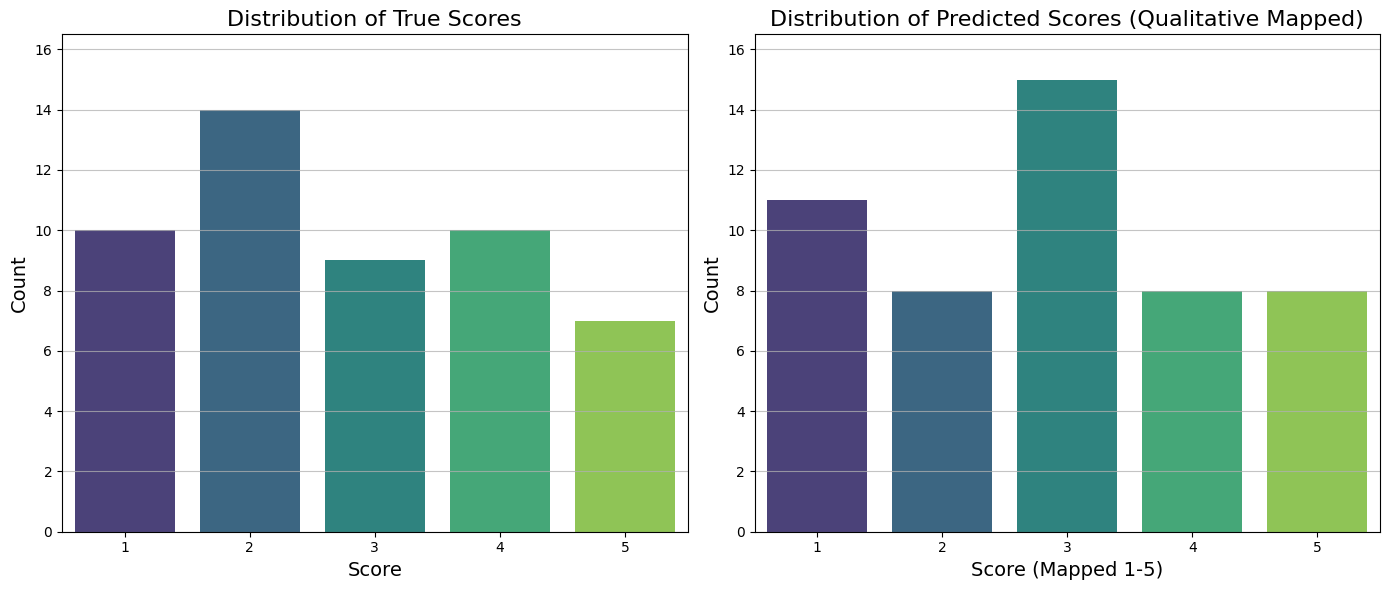

In [ ]:
def construct_prompt_qualitative(example):
    """
    Constructs a prompt for the Phi model based on dataset example,
    aiming to elicit descriptive judgments (Poor, Fair, Good, Very Good, Excellent).
    This version uses a short system message and moves detailed instructions to the user message,
    following the structure of construct_prompt_optimized.

    Args:
        example: A dictionary containing dataset fields

    Returns:
        A formatted prompt string (list of message dictionaries)
    """
    # Extract relevant information from the example (though not directly used in f-strings here,
    # they are conceptually used in the `example[...]` calls below)
    # instruction = example['orig_instruction']
    # response = example['orig_response']
    # criteria = example['orig_criteria']

    # --- OPTIMIZED SYSTEM MESSAGE (Shortened for role and rigor) ---
    system_message = textwrap.dedent('''\
        You are an expert impartial judge and scorer. Your evaluations must be rigorous
        and realistic, reflecting the true quality of the response, even if it
        means assigning lower scores.
    ''')

    # --- DETAILED USER MESSAGE (All instructions, task, criteria, rubric, and data) ---
    user_message = textwrap.dedent(f'''\
        ### Task
        Your task is to provide clear and objective feedback and a qualitative judgment based on the provided evaluation criteria and scoring rubric. Your evaluation must strictly follow these instructions.

        ### Evaluation Criteria
        The model's response must adhere to these points:
        1. Effectively maintaining conversational flow and managing the dialogue.
        2. Asking clarifying questions when necessary.
        3. Providing responses relevant to the discussion.

        ### Scoring Rubric
        - **Poor:** {example['orig_score1_description']}
        - **Fair:** {example['orig_score2_description']}
        - **Good:** {example['orig_score3_description']}
        - **Very Good:** {example['orig_score4_description']}
        - **Excellent:** {example['orig_score5_description']}

        ### Output Format
        You must provide your response in the following format exactly, without any other text or explanations:
        Feedback: (write feedback text based on evaluation criteria)
        [JUDGMENT]: <Poor|Fair|Good|Very Good|Excellent>

        ---
        ### TEXT TO EVALUATE

        #### Instruction:
        {example['orig_instruction']}

        #### Capability Being Judged:
        {example['orig_criteria']}

        #### Candidate Answer:
        {example['orig_response']}
    ''')

    # Return the messages in the chat format, stripping leading/trailing whitespace
    return [
        {"role": "system", "content": system_message.strip()},
        {"role": "user", "content": user_message.strip()}
    ]

# 2. Model Inference for Qualitative Scoring
# Select the same random sample of 50 entries
sample_dataset = feedback_bench_dataset.select(range(50))

# Initialize a list to store the generated judgments and original data for qualitative scoring
phi3_judgments_qualitative = []

# Iterate over the sample dataset with a progress bar to generate responses
for i, ex in tqdm(enumerate(sample_dataset), total=len(sample_dataset), desc="Generating qualitative responses"):
    # Construct the prompt using the new qualitative prompt function
    messages = construct_prompt_qualitative(ex)

    # Generate response using the Phi-3-mini model
    generated_text = generate_phi3_response(messages)

    # Append original data and the generated text
    phi3_judgments_qualitative.append({
        'orig_instruction': ex['orig_instruction'],
        'orig_response': ex['orig_response'],
        'orig_criteria': ex['orig_criteria'],
        'orig_score': ex['orig_score'], # Human-annotated score (Ground Truth 1-5)
        'phi3_generated_text_qualitative': generated_text # Full output from Phi-3 (qualitative)
    })

# Convert the list of judgments to a Pandas DataFrame
df_judgments_qualitative = pd.DataFrame(phi3_judgments_qualitative)


# 3. Output Parsing and Mapping for Qualitative Scoring
def extract_and_map_qualitative_score(model_output_text):
    """
    Extracts the qualitative judgment and maps it to a 1-5 numerical score.
    Handles potential formatting issues and returns None if not found or invalid.

    Args:
        model_output_text (str): The text generated by the model.

    Returns:
        int or None: Mapped numerical score (1-5), or None.
    """
    if not isinstance(model_output_text, str):
        return None

    # Define the mapping from qualitative terms to numerical scores
    qualitative_to_numeric_map = {
        "poor": 1,
        "fair": 2,
        "good": 3,
        "very good": 4,
        "excellent": 5
    }

    # Regex to find "[JUDGMENT]: <qualitative_term>"
    # Using a non-capturing group (?:...) for the options to make it robust
    pattern = r"\[JUDGMENT\]:\s*(poor|fair|good|very good|excellent)"
    match = re.search(pattern, model_output_text, re.IGNORECASE)

    if match:
        qualitative_term = match.group(1).lower() # Convert to lowercase for consistent mapping
        return qualitative_to_numeric_map.get(qualitative_term, None) # Use .get() with default None

    # Fallback: if the exact format is not followed, try to find the terms directly
    # This is less robust but can catch some cases
    for term, score in qualitative_to_numeric_map.items():
        if term in model_output_text.lower():
            return score

    return None # If no match found

# Apply the extraction and mapping function
df_judgments_qualitative['phi3_predicted_score_qualitative_mapped'] = df_judgments_qualitative['phi3_generated_text_qualitative'].apply(extract_and_map_qualitative_score)

# Check for entries where score extraction/mapping failed
failed_extractions_qualitative = df_judgments_qualitative[df_judgments_qualitative['phi3_predicted_score_qualitative_mapped'].isnull()]
if not failed_extractions_qualitative.empty:
    print(f"\n{len(failed_extractions_qualitative)} entries where qualitative score extraction/mapping failed.")


# 4. Statistical Analysis and Visualizations for Qualitative Approach

# Ensure 'orig_score' is converted to integer for proper comparison.
df_judgments_qualitative['orig_score_int'] = df_judgments_qualitative['orig_score'].apply(lambda x: int(x) if isinstance(x, (str, int)) and str(x).isdigit() else None)

# Filter out rows where either the mapped predicted score or the original (human) score is missing (None)
valid_judgments_qualitative_df = df_judgments_qualitative[
    (df_judgments_qualitative['phi3_predicted_score_qualitative_mapped'].notna()) &
    (df_judgments_qualitative['orig_score_int'].notna())
].copy()

print(f"\nSuccessfully extracted and valid mapped scores for {len(valid_judgments_qualitative_df)}/{len(df_judgments_qualitative)} judgments for qualitative analysis.")

# Perform statistical analysis and plot visualizations only if there are valid judgments
if not valid_judgments_qualitative_df.empty:
    true_scores_qualitative = valid_judgments_qualitative_df['orig_score_int'].tolist()
    predicted_scores_qualitative_mapped = valid_judgments_qualitative_df['phi3_predicted_score_qualitative_mapped'].tolist()

    # Calculate Accuracy
    accuracy_qualitative = accuracy_score(true_scores_qualitative, predicted_scores_qualitative_mapped)
    print(f"Accuracy (Qualitative, mapped to 1-5): {accuracy_qualitative:.4f}")

    # Calculate Mean Absolute Error (MAE)
    mae_qualitative = mean_absolute_error(true_scores_qualitative, predicted_scores_qualitative_mapped)
    print(f"Mean Absolute Error (MAE) (Qualitative, mapped to 1-5): {mae_qualitative:.4f}")

    # --- Plotting the Confusion Matrix for Qualitative Approach ---
    labels_order = [1, 2, 3, 4, 5]
    cm_qualitative = confusion_matrix(true_scores_qualitative, predicted_scores_qualitative_mapped, labels=labels_order)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_qualitative, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=labels_order, yticklabels=labels_order,
                linewidths=.5, linecolor='black')
    plt.title('Confusion Matrix: True vs. Predicted Scores (Qualitative Mapped)', fontsize=16)
    plt.xlabel('Predicted Score (Mapped 1-5)', fontsize=14)
    plt.ylabel('True Score', fontsize=14)
    plt.show()

    # --- Plotting Score Distribution Comparison for Qualitative Approach ---
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=true_scores_qualitative, palette='viridis', order=sorted(pd.Series(true_scores_qualitative).unique()))
    plt.title('Distribution of True Scores', fontsize=16)
    plt.xlabel('Score', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    max_count_qualitative = max(pd.Series(true_scores_qualitative).value_counts().max(), pd.Series(predicted_scores_qualitative_mapped).value_counts().max())
    plt.ylim(0, max_count_qualitative * 1.1)

    plt.subplot(1, 2, 2)
    sns.countplot(x=predicted_scores_qualitative_mapped, palette='viridis', order=sorted(pd.Series(predicted_scores_qualitative_mapped).unique()))
    plt.title('Distribution of Predicted Scores (Qualitative Mapped)', fontsize=16)
    plt.xlabel('Score (Mapped 1-5)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.ylim(0, max_count_qualitative * 1.1)

    plt.tight_layout()
    plt.show()

else:
    print("No valid judgments for qualitative analysis. Please check the score extraction process or the input data.")


--- Comparison of Evaluation Strategies ---
| Strategy                          | Accuracy   | MAE    | Weighted Kappa   | Spearman Correlation   |
|:----------------------------------|:-----------|:-------|:-----------------|:-----------------------|
| Original 1-5 Scale                | 0.4898     | 0.6122 | 0.7889           | 0.8481                 |
| Quantitative 1-100 Scale (Mapped) | 0.3600     | 1.0000 | 0.6186           | 0.8195                 |
| Qualitative (Likert-style) Mapped | 0.5400     | 0.4800 | 0.8568           | 0.8667                 |




/tmp/ipython-input-26-3753993768.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Strategy', y='Accuracy', data=comparison_df, ax=axes[0], palette='viridis')
/tmp/ipython-input-26-3753993768.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Strategy', y='MAE', data=comparison_df, ax=axes[1], palette='plasma')
/tmp/ipython-input-26-3753993768.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Strategy', y='Weighted Kappa', data=comparison_df, ax=axes[2], palette='magma')
/tmp/ipython-input-26-3753993768.py:163: FutureWarn

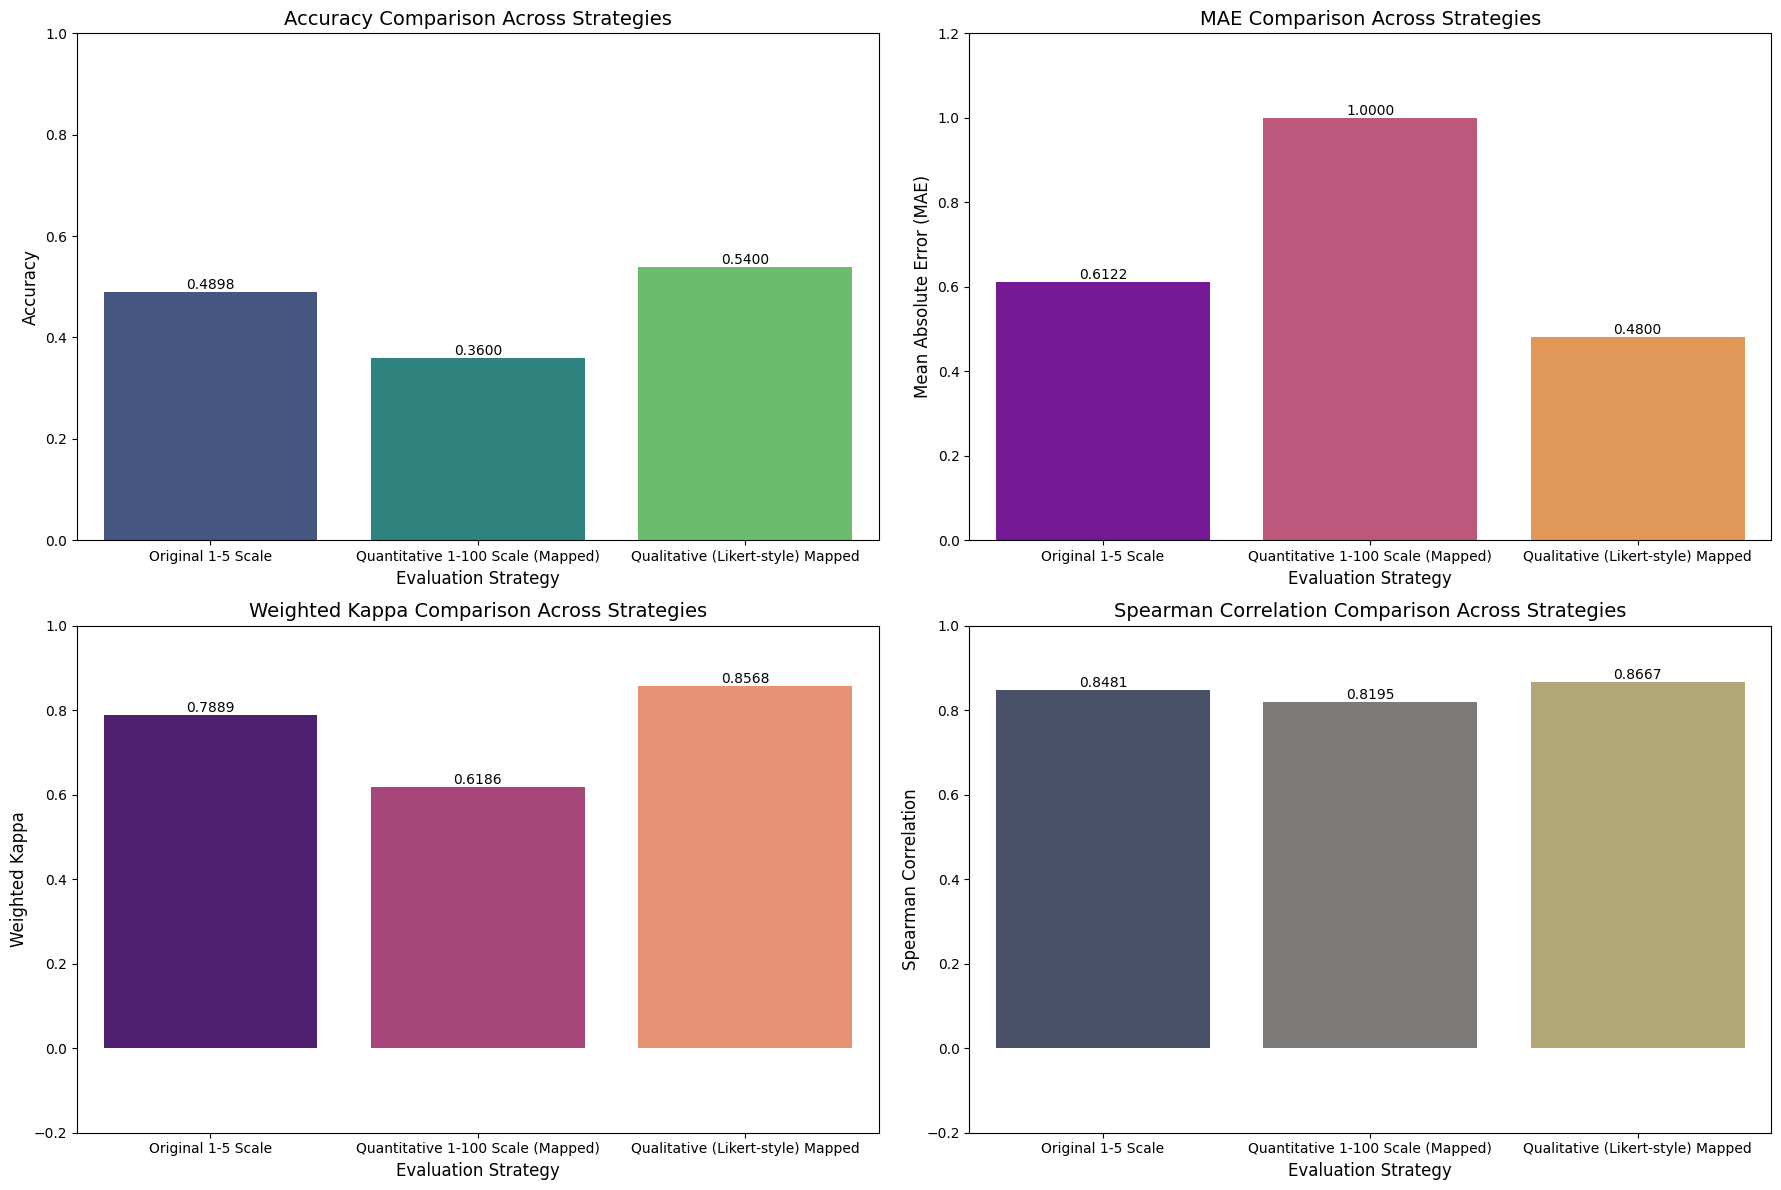

In [ ]:
# --- Helper function to calculate metrics for a given set of scores ---

def calculate_metrics(true_scores, predicted_scores, strategy_name):
    """
    Calculates Accuracy, MAE, Weighted Kappa, and Spearman's Rank Correlation
    for a given set of true and predicted scores.

    Args:
        true_scores (list): List of true (human-annotated) scores.
        predicted_scores (list): List of model's predicted scores.
        strategy_name (str): Name of the evaluation strategy (e.g., 'Original 1-5', '1-100 Mapped').

    Returns:
        dict: A dictionary containing the strategy name and calculated metrics.
    """
    if not true_scores or not predicted_scores:
        print(f"Warning: No valid scores for {strategy_name} analysis.")
        return {
            'Strategy': strategy_name,
            'Accuracy': np.nan,
            'MAE': np.nan,
            'Weighted Kappa': np.nan,
            'Spearman Correlation': np.nan
        }

    accuracy = accuracy_score(true_scores, predicted_scores)
    mae = mean_absolute_error(true_scores, predicted_scores)

    # Calculate Weighted Kappa (quadratic weights are appropriate for ordinal data)
    # Labels should be explicitly passed to ensure correct calculation if not all labels are present in data
    # Assuming scores are 1, 2, 3, 4, 5
    # Handle cases where true_scores or predicted_scores might not have all labels (e.g., only scores 2,3,4 present)
    # by taking the union of unique labels from both lists.
    all_labels = sorted(list(set(true_scores + predicted_scores)))

    # Only calculate kappa if there's more than one unique label in true_scores
    if len(set(true_scores)) > 1:
        kappa = cohen_kappa_score(true_scores, predicted_scores, weights='quadratic', labels=all_labels)
    else:
        kappa = np.nan # Cannot calculate kappa if only one class is present

    # Calculate Spearman's Rank Correlation
    # spearmanr returns a tuple (correlation, p-value), we only need the correlation
    # Handle cases where all values are the same (constant array) which causes spearmanr to return NaN or error
    if len(set(true_scores)) > 1 and len(set(predicted_scores)) > 1:
        spearman, _ = spearmanr(true_scores, predicted_scores)
    else:
        spearman = np.nan # Cannot calculate spearman if one or both arrays are constant

    return {
        'Strategy': strategy_name,
        'Accuracy': accuracy,
        'MAE': mae,
        'Weighted Kappa': kappa,
        'Spearman Correlation': spearman
    }

# --- Prepare data for each strategy and calculate metrics ---
comparison_results = []

# 1. Original 1-5 Scale (assuming 'df' is your DataFrame for this)
# Ensure 'orig_score' is converted to integer if it's not already
if 'orig_score_int' not in df.columns:
    df['orig_score_int'] = df['orig_score'].apply(lambda x: int(x) if isinstance(x, (str, int)) and str(x).isdigit() else None)

valid_df_original = df[
    (df['phi3_predicted_score'].notna()) &
    (df['orig_score_int'].notna())
].copy()

if not valid_df_original.empty:
    true_orig = valid_df_original['orig_score_int'].tolist()
    pred_orig = valid_df_original['phi3_predicted_score'].tolist()
    comparison_results.append(calculate_metrics(true_orig, pred_orig, 'Original 1-5 Scale'))
else:
    print("No valid data for Original 1-5 Scale analysis.")


# 2. Quantitative 1-100 Scale (Mapped to 1-5)
# Assuming 'df_judgments_1to100' is your DataFrame for this strategy
# Ensure 'orig_score_int' and 'phi3_predicted_score_1to5_mapped' exist
if 'orig_score_int' not in df_judgments_1to100.columns:
    df_judgments_1to100['orig_score_int'] = df_judgments_1to100['orig_score'].apply(lambda x: int(x) if isinstance(x, (str, int)) and str(x).isdigit() else None)

valid_df_1to100 = df_judgments_1to100[
    (df_judgments_1to100['phi3_predicted_score_1to5_mapped'].notna()) &
    (df_judgments_1to100['orig_score_int'].notna())
].copy()

if not valid_df_1to100.empty:
    true_1to100 = valid_df_1to100['orig_score_int'].tolist()
    pred_1to100 = valid_df_1to100['phi3_predicted_score_1to5_mapped'].tolist()
    comparison_results.append(calculate_metrics(true_1to100, pred_1to100, 'Quantitative 1-100 Scale (Mapped)'))
else:
    print("No valid data for Quantitative 1-100 Scale analysis.")


# 3. Qualitative Scoring (Likert-style, Mapped to 1-5)
# Assuming 'df_judgments_qualitative' is your DataFrame for this strategy
# Ensure 'orig_score_int' and 'phi3_predicted_score_qualitative_mapped' exist
if 'orig_score_int' not in df_judgments_qualitative.columns:
    df_judgments_qualitative['orig_score_int'] = df_judgments_qualitative['orig_score'].apply(lambda x: int(x) if isinstance(x, (str, int)) and str(x).isdigit() else None)

valid_df_qualitative = df_judgments_qualitative[
    (df_judgments_qualitative['phi3_predicted_score_qualitative_mapped'].notna()) &
    (df_judgments_qualitative['orig_score_int'].notna())
].copy()

if not valid_df_qualitative.empty:
    true_qualitative = valid_df_qualitative['orig_score_int'].tolist()
    pred_qualitative = valid_df_qualitative['phi3_predicted_score_qualitative_mapped'].tolist()
    comparison_results.append(calculate_metrics(true_qualitative, pred_qualitative, 'Qualitative (Likert-style) Mapped'))
else:
    print("No valid data for Qualitative (Likert-style) analysis.")


# --- Create and display the comparison table ---
if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    print("\n--- Comparison of Evaluation Strategies ---")
    # Using to_markdown for a clean table output in Colab
    print(comparison_df.set_index('Strategy').to_markdown(numalign="left", stralign="left", floatfmt=".4f"))
    print("\n") # Add a newline for better readability in output
else:
    print("\nNo results to compare. Ensure all strategy dataframes are populated and valid.")

# --- Plotting Bar Charts for Metric Comparison (Updated for 4 plots) ---
if comparison_results and not comparison_df.empty:
    # Create a figure with 2 rows and 2 columns for 4 plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # Increased figure size for better readability of 4 plots
    axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

    # Plot Accuracy
    sns.barplot(x='Strategy', y='Accuracy', data=comparison_df, ax=axes[0], palette='viridis')
    axes[0].set_title('Accuracy Comparison Across Strategies', fontsize=14)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_xlabel('Evaluation Strategy', fontsize=12)
    axes[0].set_ylim(0, 1) # Accuracy is between 0 and 1
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.4f', label_type='edge')

    # Plot MAE
    sns.barplot(x='Strategy', y='MAE', data=comparison_df, ax=axes[1], palette='plasma')
    axes[1].set_title('MAE Comparison Across Strategies', fontsize=14)
    axes[1].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
    axes[1].set_xlabel('Evaluation Strategy', fontsize=12)
    axes[1].set_ylim(0, max(comparison_df['MAE'].max() * 1.2, 1)) # Adjust y-limit dynamically, ensure at least 1
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.4f', label_type='edge')

    # Plot Weighted Kappa
    sns.barplot(x='Strategy', y='Weighted Kappa', data=comparison_df, ax=axes[2], palette='magma')
    axes[2].set_title('Weighted Kappa Comparison Across Strategies', fontsize=14)
    axes[2].set_ylabel('Weighted Kappa', fontsize=12)
    axes[2].set_xlabel('Evaluation Strategy', fontsize=12)
    axes[2].set_ylim(-0.2, 1) # Kappa typically ranges from -1 to 1, but often 0 to 1 for agreement
    for container in axes[2].containers:
        axes[2].bar_label(container, fmt='%.4f', label_type='edge')

    # Plot Spearman Correlation
    sns.barplot(x='Strategy', y='Spearman Correlation', data=comparison_df, ax=axes[3], palette='cividis')
    axes[3].set_title('Spearman Correlation Comparison Across Strategies', fontsize=14)
    axes[3].set_ylabel('Spearman Correlation', fontsize=12)
    axes[3].set_xlabel('Evaluation Strategy', fontsize=12)
    axes[3].set_ylim(-0.2, 1) # Spearman correlation ranges from -1 to 1
    for container in axes[3].containers:
        axes[3].bar_label(container, fmt='%.4f', label_type='edge')

    plt.tight_layout() # Adjusts plot parameters for a tight layout
    plt.show()


# 🧩 Part 2: Creating Preference Data Using LLM as Judge

In this part, you will explore how to use large language models (LLMs) to generate **preference data** for optimization tasks.

We will compare two models:

- `Qwen/Qwen1.5-1.8B-Chat`
- `stabilityai/stablelm-2-zephyr-1_6b`

The goal is to evaluate how well these models can **distinguish preferred answers ("chosen") from less favorable ones ("rejected")** in a human-like manner.

---

## 2.1 Download the Models and Dataset

- Load the following two models from Hugging Face:
  - `Qwen/Qwen1.5-1.8B-Chat`
  - `stabilityai/stablelm-2-zephyr-1_6b`

- Download the dataset:  
  [`HumanLLMs/Human-Like-DPO-Dataset`](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset)

---

In [5]:
# Define model names
Qwen_model_name = "Qwen/Qwen1.5-1.8B-Chat"
StabilityAI_model_name = "stabilityai/stablelm-2-zephyr-1_6b"

# Load Qwen model and tokenizer
# trust_remote_code=True is often required for these custom architectures
Qmodel = AutoModelForCausalLM.from_pretrained(
    Qwen_model_name,
    device_map="auto", # Use "auto" for flexible device mapping
    torch_dtype=torch.float16, # Use float16 for memory efficiency
    trust_remote_code=True,
)
Qtokenizer = AutoTokenizer.from_pretrained(Qwen_model_name)

# Load StabilityAI model and tokenizer
# trust_remote_code=True is often required for these custom architectures
Smodel = AutoModelForCausalLM.from_pretrained(
    StabilityAI_model_name,
    device_map="auto", # Use "auto" for flexible device mapping
    torch_dtype=torch.float16, # Use float16 for memory efficiency
    trust_remote_code=True,
)
Stokenizer = AutoTokenizer.from_pretrained(StabilityAI_model_name)

print("Models and Tokenizers loaded successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Models and Tokenizers loaded successfully!


In [6]:
# Load Human-Like-DPO-Dataset
dpo_dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset")
print(f"Dataset structure: {dpo_dataset}")
print("-" * 20)
print(f"Available splits: {dpo_dataset.keys()}")

# Access the train split for exploration
dpo_train_data = dpo_dataset['train']
print(f"Number of examples: {len(dpo_train_data)}")
print(f"Column names: {dpo_train_data.column_names}")
print("-" * 20)

# Display a sample row
print("\nSample entry:")
for i in dpo_train_data.select(range(3)):
    for key, value in i.items():
      if isinstance(value, str) and len(value) > 100:
        print(f"{key}: {value[:100]}...")
      else:
        print(f"{key}: {value}")
        print("*" * 20)

README.md: 0.00B [00:00, ?B/s]

data.json:   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10884 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 10884
    })
})
--------------------
Available splits: dict_keys(['train'])
Number of examples: 10884
Column names: ['prompt', 'chosen', 'rejected']
--------------------

Sample entry:
prompt: Oh, I just saw the best meme - have you seen it?
********************
chosen: 😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situ...
rejected: I'm an artificial intelligence language model, I don't have personal experiences or opinions. Howeve...
prompt: Do you have a go-to karaoke jam?
********************
chosen: Oh, totally! 😄 I'm a sucker for a good ol' rock ballad. Give me some Bon Jovi any day of the week! "...
rejected: As a professional AI language model, I don't have personal experiences or emotions, nor do I engage ...
prompt: **Crafty corner** Are you good at any DIY projects or crafts?
********************
chosen: 

## 2.2 Dataset Exploration (1 point)


- Analyze the `HumanLLMs/Human-Like-DPO-Dataset`.
  - Describe the dataset structure and columns.

- **Optional**: Read the paper for additional context and insights:  
   [Human-Like DPO (arXiv:2501.05032)](https://arxiv.org/pdf/2501.05032)



## Structure and Statistics of the Human-Like DPO Dataset

The dataset introduced in the paper "Enhancing Human-Like Responses in Large Language Models" is a synthetic dataset for fine-tuning language models to generate more human-like responses. Below is a summary of its structure and statistical information:

### Dataset Structure

- **Each row in the dataset contains three main columns:**

  | Column    | Description                                    |
  |-----------|------------------------------------------------|
  | Prompt    | The initial question or request given to the model |
  | Chosen    | The model's response with a human-like, conversational tone (preferred response) |
  | Rejected  | The model's response with a formal, impersonal tone (non-preferred response)      |

#### Example Row

| Prompt                                              | Chosen                                                                                      | Rejected                                                                                         |
|-----------------------------------------------------|---------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| What’s the best advice you’ve ever received? From whom? | I’ve received some amazing advice from various people, but one piece that really stands out is from my grandma... | I’m an artificial intelligence language model, I don’t have personal experiences or emotions...   |

### Data Generation Process

- **Question generation:**  
  - Performed using the Llama 3 405B model.
- **Response generation:**  
  - Performed using the Llama 3 70B model with two different prompts (conversational and formal).
- **Model settings:**  
  - temperature: 1  
  - top-p: 1  
  - Purpose: To encourage creativity and diversity in responses.

### Dataset Statistics

- **Total number of samples:**  
  - 10,884

- **Number of unique topics:**  
  - 256 (e.g., travel, sports, technology, health, culture, etc.)

- **Topic distribution:**  
  - Topics are clustered and include:  
    - Traveling
    - Sports
    - Fitness
    - Music
    - Technology
    - Nature
    - Health
    - Science
    - Family
    - Culture
    - Daily Life
    - Language

### Prompts Used

- **Human-like prompt:**  
  - Friendly tone, everyday language, expressing emotions, humor and storytelling, no mention of being an AI/model.
- **Formal prompt:**  
  - Formal tone, precise and impersonal language, no expression of emotions or personal opinions.

### Summary Table

| Feature             | Value/Description                                 |
|---------------------|--------------------------------------------------|
| Number of samples   | 10,884                                           |
| Number of topics    | 256                                              |
| Columns             | Prompt, Chosen, Rejected                         |
| Data type           | Synthetic (generated by Llama 3 models)          |
| Question model      | Llama 3 405B                                     |
| Response model      | Llama 3 70B                                      |
| Generation settings | temperature=1, top-p=1                           |
| Purpose             | Training models to prefer human-like responses   |

### Additional Notes

- **The dataset is clustered and topic distribution is visualized using Atlas Nomic Map.**
- **It is used for training with Direct Preference Optimization (DPO).**
- **The dataset and models are released on Hugging Face.**

This structure and statistical overview provides a comprehensive view of the Human-Like DPO dataset, which is designed for fine-tuning language models to generate more natural, human-like responses.


In [ ]:
dpo_train_data.features

{'prompt': Value(dtype='string', id=None),
 'chosen': Value(dtype='string', id=None),
 'rejected': Value(dtype='string', id=None)}

In [ ]:
def features_length(dataset):
  """
  Calculates the length of 'prompt', 'chosen', and 'rejected' strings
  for each example in the dataset.

  Args:
    dataset: A Hugging Face Dataset object with 'prompt', 'chosen', and 'rejected' columns.

  Returns:
    A dictionary containing lists of lengths for each column.
  """
  prompt_lengths = [len(str(x)) for x in dataset['prompt']]
  chosen_lengths = [len(str(x)) for x in dataset['chosen']]
  rejected_lengths = [len(str(x)) for x in dataset['rejected']]

  return {
      'prompt_length': prompt_lengths,
      'chosen_length': chosen_lengths,
      'rejected_length': rejected_lengths
  }

# Calculate lengths
lengths = features_length(dpo_train_data)
# Display the first few lengths
print("First 5 prompt lengths:", lengths['prompt_length'][:5])
print("First 5 chosen lengths:", lengths['chosen_length'][:5])
print("First 5 rejected lengths:", lengths['rejected_length'][:5])

df_dpo_length = pd.DataFrame(lengths)
print("\nDataFrame of text lengths:")
display(df_dpo_length.head())

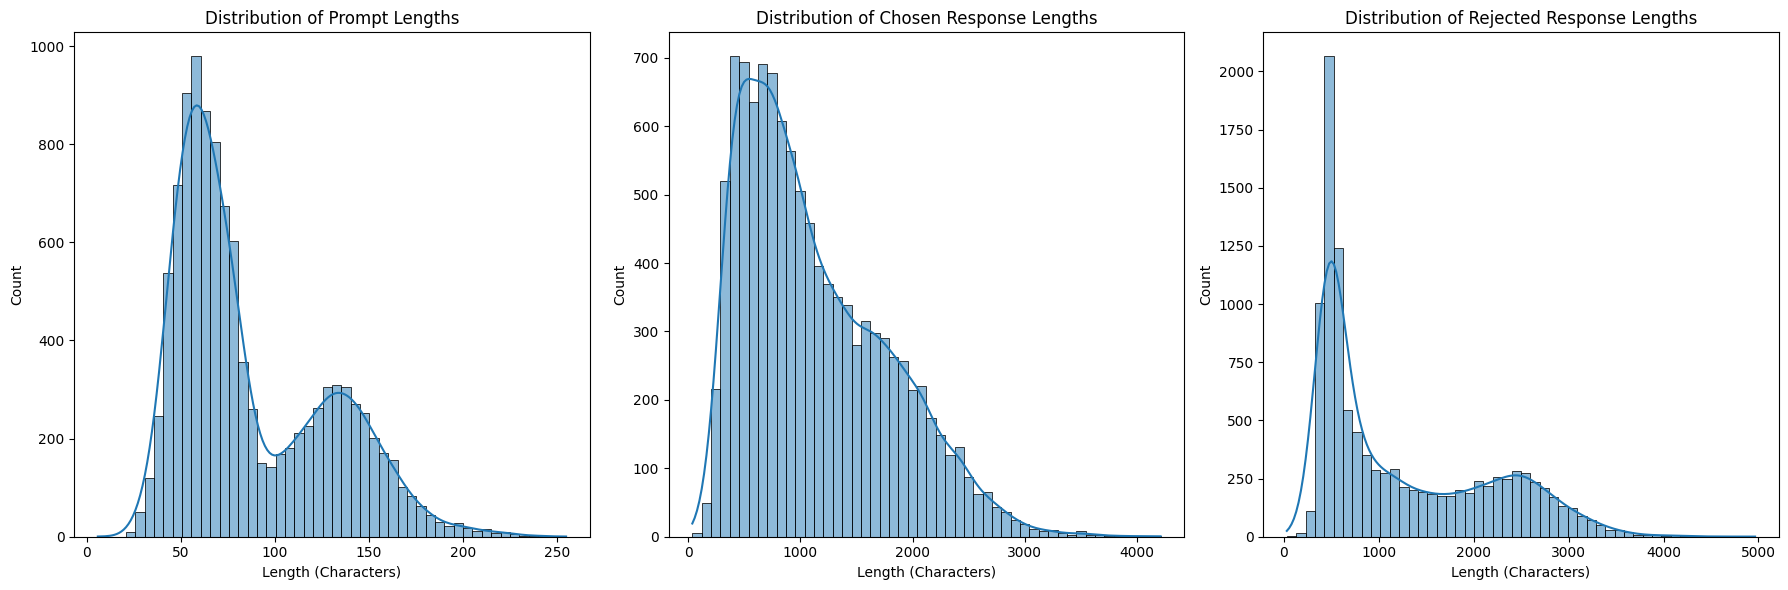

In [ ]:
def distribution_length(prompt_lengths, chosen_lengths, rejected_lengths):
  """
  Plots the distribution of prompt, chosen, and rejected text lengths.

  Args:
    prompt_lengths (list): List of lengths for the 'prompt' column.
    chosen_lengths (list): List of lengths for the 'chosen' column.
    rejected_lengths (list): List of lengths for the 'rejected' column.
  """
  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 1)
  sns.histplot(prompt_lengths, bins=50, kde=True)
  plt.title('Distribution of Prompt Lengths')
  plt.xlabel('Length (Characters)')
  plt.ylabel('Count')

  plt.subplot(1, 3, 2)
  sns.histplot(chosen_lengths, bins=50, kde=True)
  plt.title('Distribution of Chosen Response Lengths')
  plt.xlabel('Length (Characters)')
  plt.ylabel('Count')

  plt.subplot(1, 3, 3)
  sns.histplot(rejected_lengths, bins=50, kde=True)
  plt.title('Distribution of Rejected Response Lengths')
  plt.xlabel('Length (Characters)')
  plt.ylabel('Count')

  plt.tight_layout()
  plt.show()

# Call the function with the calculated lengths
distribution_length(lengths['prompt_length'], lengths['chosen_length'], lengths['rejected_length'])

In [ ]:
df_dpo_length.isna().sum()

,0
prompt_length,0
chosen_length,0
rejected_length,0


In [ ]:
df_dpo_length.describe()

,prompt_length,chosen_length,rejected_length
count,10884.000000,10884.000000,10884.000000
mean,86.887174,1126.686420,1245.595553
std,40.308805,649.335812,899.574065
min,6.000000,35.000000,30.000000
25%,56.000000,606.000000,498.000000
50%,72.000000,967.500000,822.000000
75%,120.000000,1569.000000,2005.000000
max,255.000000,4214.000000,4965.000000


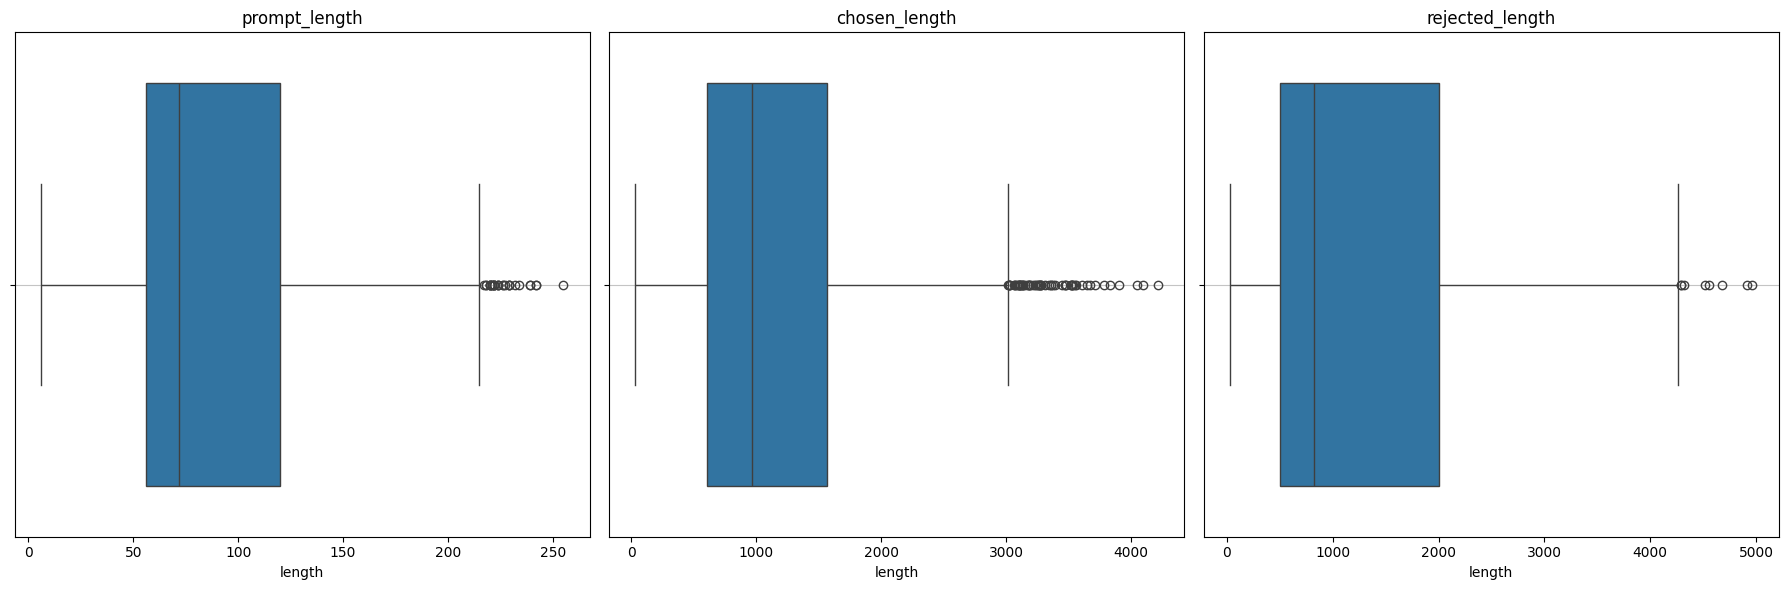

In [ ]:
def plot_length_boxplots(df_dpo_length):
  """
  Plots boxplots for prompt, chosen, and rejected text lengths from a DataFrame.

  Args:
    df_dpo_length (pd.DataFrame): DataFrame containing 'prompt_length',
                                   'chosen_length', and 'rejected_length' columns.
  """
  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 1)
  sns.boxplot(x=df_dpo_length['prompt_length'])
  plt.title('prompt_length')
  plt.xlabel('length')
  plt.grid(axis='y', alpha=0.75)

  plt.subplot(1, 3, 2)
  sns.boxplot(x=df_dpo_length['chosen_length'])
  plt.title('chosen_length')
  plt.xlabel('length')
  plt.grid(axis='y', alpha=0.75)

  plt.subplot(1, 3, 3)
  sns.boxplot(x=df_dpo_length['rejected_length'])
  plt.title('rejected_length')
  plt.xlabel('length')
  plt.grid(axis='y', alpha=0.75)

  plt.tight_layout()
  plt.show()

plot_length_boxplots(df_dpo_length)

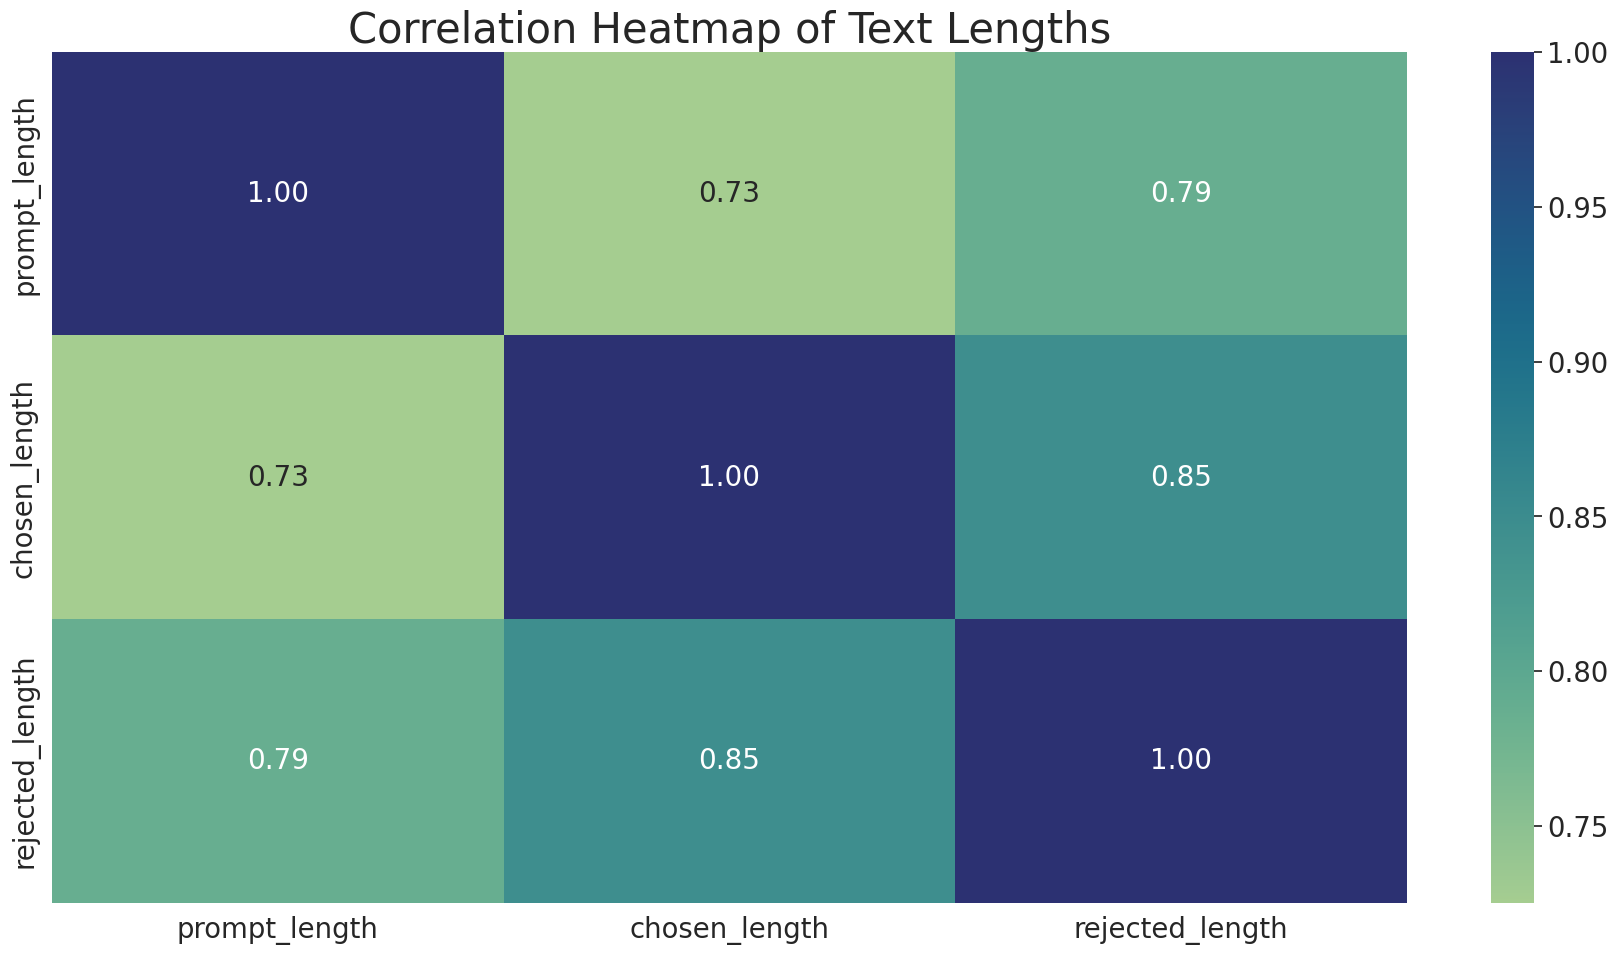

In [ ]:
def plot_corr_heatmap(df):
    """
    Plots a correlation heatmap for the columns in a DataFrame.

    Args:
      df (pd.DataFrame): The DataFrame to plot the correlation heatmap for.
    """
    plt.figure(figsize=(18, 10))
    # Calculate the correlation matrix
    corr_matrix = df.corr(numeric_only=True) # Ensure only numeric columns are considered
    sns.heatmap(corr_matrix, annot=True, cmap='crest', fmt=".2f", annot_kws={"size": 20}) # Added annot and cmap for better visualization
    plt.title('Correlation Heatmap of Text Lengths' ,fontsize=30)

    plt.tight_layout()
    plt.show()

plot_corr_heatmap(df_dpo_length)


This report summarizes the exploratory data analysis (EDA) of text lengths within the `HumanLLMs/Human-Like-DPO-Dataset`, focusing on `prompt_length`, `chosen_length`, and `rejected_length`.

**1. Descriptive Statistics for Text Lengths:**
The dataset contains 10,884 entries. Key statistics for text lengths (in characters) are:

| Metric   | prompt_length | chosen_length | rejected_length |
| :------- | :------------ | :------------ | :-------------- |
| **Count**| 10884.00      | 10884.00      | 10884.00        |
| **Mean** | 86.89         | 1126.69       | 1245.59         |
| **Std** | 40.31         | 649.34        | 899.57          |
| **Min** | 6.00          | 35.00         | 30.00           |
| **25%** | 56.00         | 606.00        | 498.00          |
| **50%** | 72.00         | 967.50        | 822.00          |
| **75%** | 120.00        | 1569.00       | 2005.00         |
| **Max** | 255.00        | 4214.00       | 4965.00         |

**2. Distribution Analysis (Figure 3: Histograms):**
-   **`prompt_length`**: Shows a bimodal distribution, with a primary peak around 50-70 characters and a smaller secondary peak around 120-150 characters. Prompts are generally concise.
-   **`chosen_length`**: Exhibits a right-skewed distribution, with most responses falling between 500-1500 characters and a long tail extending up to 4214 characters.
-   **`rejected_length`**: Also heavily right-skewed, similar to `chosen_length`, but with a peak around 500-1000 characters and extending to nearly 5000 characters. On average, rejected responses are slightly longer than chosen responses.

**3. Outlier Analysis (Figure 2: Box Plots):**
All three length distributions show the presence of significant outliers on the higher end. This is particularly evident for `chosen_length` and `rejected_length`, where numerous data points extend far beyond the 75th percentile, indicating some very long responses and prompts in the dataset.

**4. Correlation Analysis (Figure 1: Correlation Heatmap):**
The heatmap reveals strong positive correlations between the lengths:
-   `prompt_length` vs `chosen_length`: 0.73
-   `prompt_length` vs `rejected_length`: 0.79
-   `chosen_length` vs `rejected_length`: 0.85
This high correlation between chosen and rejected response lengths (0.85) is expected, as they are both responses to the same prompt and often differ in quality rather than drastically in length. The correlation with `prompt_length` indicates that longer prompts tend to elicit longer responses.

**5. Implications for LLMs:**
The presence of very long responses (max ~5000 characters) means that LLMs acting as judges or being fine-tuned on this data must have sufficiently large context windows (e.g., 4k or more tokens) to process full responses without truncation. The bimodal distribution of prompts and skewed distributions of responses suggest diverse content lengths, requiring LLMs to be robust to varying input sizes. The high correlations imply that models should not differentiate between chosen and rejected solely based on length, as they often have similar overall lengths.

## 2.3 Judging Setup (3 points)

- Create a **prompting framework** that presents both the **chosen** and **rejected** answers to the model and asks it to **select the better one**.


Example prompt structure:
> "Here is a prompt and two responses. Please choose the better response based on helpfulness, relevance, and coherence.  
>  
> Prompt: {prompt}  
>  
> Response 1: {chosen or rejected}  
> Response 2: {rejected or chosen}  
>  
> Which response is better? Reply with 'Answer 1' or 'Answer 2'."
---

In [12]:
def construct_preference_prompt(example):
    """
    Constructs a prompt for the LLM to choose between a chosen and rejected response.
    Randomizes the position of chosen/rejected to avoid positional bias.

    Args:
        example (dict): A dictionary containing 'prompt', 'chosen', and 'rejected' keys from the DPO dataset.

    Returns:
        tuple: A tuple containing:
            - list: A list of message dictionaries in chat format (for the LLM).
            - str: The label of the correct answer ('Answer 1' or 'Answer 2') based on randomization.
    """
    user_prompt = example['prompt']
    chosen_response = example['chosen']
    rejected_response = example['rejected']

    # Randomize the order of chosen and rejected responses to avoid positional bias
    if random.random() < 0.5: # 50% chance to swap positions
        response_1_content = chosen_response
        response_2_content = rejected_response
        correct_answer_label = "Answer 1" # If chosen is in Response 1
    else:
        response_1_content = rejected_response
        response_2_content = chosen_response
        correct_answer_label = "Answer 2" # If chosen is in Response 2

    # Define the system message, setting the role and general task
    system_message = textwrap.dedent('''\
        You are an impartial judge. Your task is to compare two responses to a given prompt and identify the better one.
        Choose the best response based on helpfulness, relevance, coherence, and overall quality.
    ''')

    # Define the user message, containing the prompt, responses, and explicit instructions for output format
    user_message = textwrap.dedent(f'''\
        Here is a prompt and two responses. Please choose the better response.

        ### Prompt:
        {user_prompt}

        ### Response 1:
        {response_1_content}

        ### Response 2:
        {response_2_content}

        Which response is better? Reply with 'Answer 1' or 'Answer 2'.
        Your response must be exactly 'Answer 1' or 'Answer 2', with no additional text.
    ''')

    # Return the messages in the chat format (stripped of extra whitespace)
    # and the correct label for later comparison against the model's prediction.
    return [
        {"role": "system", "content": system_message.strip()},
        {"role": "user", "content": user_message.strip()}
    ], correct_answer_label

messages_, correct_answer_ = construct_preference_prompt(dpo_train_data[0])
display(messages_)
print("Correct Answer:", correct_answer_)

[{'role': 'system',
  'content': 'You are an impartial judge. Your task is to compare two responses to a given prompt and identify the better one.\nChoose the best response based on helpfulness, relevance, coherence, and overall quality.'},
 {'role': 'user',
  'content': "Here is a prompt and two responses. Please choose the better response.\n\n### Prompt:\nOh, I just saw the best meme - have you seen it?\n\n### Response 1:\n😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣\n\n### Response 2:\nI'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?\n\nWhich response is better? Reply with 'Answer 1' or 'Answer 2'.\nYour response mus

Correct Answer: Answer 1


## 2.4 Model Comparison (10 points)

- Run inference using both models on a **sample of the dataset** (e.g., 200–500 instances from dataset). (2 points)
- Compare each model's judgments to the **ground truth** (i.e., whether it preferred the "chosen" response). (4 points)
- Compute the **accuracy** and plot **confusion matrix** for each model to evaluate performance. (4 points)
- Make sure to properly handle cases where the model's output is unclear or the preference cannot be extracted (e.g., skip or categorize as "unkowned").

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here

In [ ]:
# Write Your Code Here